# Business goal

To develop a predictive analytics model that accurately forecasts the cost of medical treatments and procedures. This model aims to enhance financial transparency for patients, optimize pricing strategies for healthcare providers, and contribute to the overall efficiency of the healthcare system by enabling data-driven decision-making. By leveraging historical data and machine learning algorithms, the project seeks to provide reliable price estimates that reflect the complexity and variability of individual patient care, ultimately leading to improved patient satisfaction and trust in healthcare services.

# Import the libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import sweetviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from scipy import stats
import statsmodels.api as sm
from yellowbrick.model_selection import FeatureImportances
import joblib
import shap
import pickle
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

# set seaborn style for plots
sns.set_style(style="darkgrid")

# Get the data

## Import xlsx file

In [2]:
data = pd.read_excel('dataset/Package Pricing at Mission Hospital - Data Supplement.xlsx', sheet_name='MH-Raw Data')
data.columns = data.columns.str.strip()

## Data Clean up

In [3]:
data['PAST MEDICAL HISTORY CODE'] = data['PAST MEDICAL HISTORY CODE'].str.capitalize()
data['MODE OF ARRIVAL'] = data['MODE OF ARRIVAL'].str.capitalize()
data['STATE AT THE TIME OF ARRIVAL'] = data['STATE AT THE TIME OF ARRIVAL'].str.capitalize()
data['TYPE OF ADMSN'] = data['TYPE OF ADMSN'].str.capitalize()
data['MARITAL STATUS'] = data['MARITAL STATUS'].str.capitalize()

In [4]:
data['AGE'] = data['AGE'].astype('int64')

In [5]:
mean_age = data['AGE'][data['AGE'] > 0].mean()
data.loc[(data['AGE'] == 0) & (data['MARITAL STATUS'] == 'Married'), 'AGE'] = mean_age

C:\Users\mzing\AppData\Local\Temp\ipykernel_5376\1188523340.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '29.820833333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[(data['AGE'] == 0) & (data['MARITAL STATUS'] == 'Married'), 'AGE'] = mean_age


In [6]:
data['AGE'] = data['AGE'].astype('int64')

In [7]:
data.replace({
    'GENDER': {'F': 'Female', 'M': 'Male'},
    'IMPLANT USED (Y/N)': {'Y': 'Yes', 'N': 'No'},
    'PAST MEDICAL HISTORY CODE': {'Hypertension1': 'Hypertension 1', 'Hypertension2': 'Hypertension 2', 
                                 'Diabetes1': 'Diabetes 1', 'Diabetes2': 'Diabetes 2', 'Hypertension3': 'Hypertension 3'},
    'KEY COMPLAINTS -CODE': {'other- heart': 'Other heart', 'other-tertalogy': 'Other tertalogy', 'other- respiratory': 'Other respiratory',
                            'other-nervous': 'Other nervous', 'other-general': 'Other general'}
}, inplace=True)

# Data Preparation

## Feature Engineering

In [8]:
#Age Group Bins
data['AGE_GROUP'] = 'Old'

conditions = [
    (data['AGE'] <= 10),
    (data['AGE'] > 10) & (data['AGE'] <= 25),
    (data['AGE'] > 25) & (data['AGE'] <= 50)
]

age_groups = ['Child', 'Youngadult', 'Adult']

data['AGE_GROUP'] = np.select(conditions, age_groups, default='Old')

#Haemoglobin Bins
data['HB_LEVEL'] = 'Normal'

condition = data['HB'] < 11

data.loc[condition, 'HB_LEVEL'] = 'Low'


# Urea Bins
data['UREA_LEVEL'] = np.where(data['UREA'] < 20, 'Normal', 'Abnormal')

# BMI Calculation and Bins
# Calculate BMI
data['BMI_VALUE'] = data['BODY WEIGHT'] / (data['BODY HEIGHT']/100) ** 2

# Create BMI Categories
conditions = [
    (data['BMI_VALUE'] <= 18.5),
    (data['BMI_VALUE'] > 18.5) & (data['BMI_VALUE'] < 25),
    (data['BMI_VALUE'] >= 25) & (data['BMI_VALUE'] < 30),
    (data['BMI_VALUE'] >= 30)
]
categories = ['Underweight', 'Normal', 'Overweight', 'Obese']
data['BMI'] = np.select(conditions, categories, default='Obese')

# Blood Pressure Categories
conditions = [
    (data['BP -HIGH'] < 120) & (data['BP-LOW'] < 80),
    (data['BP -HIGH'] > 119) & (data['BP -HIGH'] < 130) & (data['BP-LOW'] < 80),
    ((data['BP -HIGH'] > 129) & (data['BP -HIGH'] < 140)) | ((data['BP-LOW'] > 79) & (data['BP-LOW'] < 90)),
    (data['BP -HIGH'] >= 140) | (data['BP-LOW'] >= 90),
    (data['BP -HIGH'] > 180) | (data['BP-LOW'] > 120)
]
categories = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']
data['BP_Cat'] = np.select(conditions, categories, default='Hypertensive Crisis')

# Creatinine Level Bins
conditions = [
    (data['AGE'] <= 3) & (data['CREATININE'] >= 0.3) & (data['CREATININE'] <= 0.7),
    (data['AGE'] > 3) & (data['AGE'] <= 18) & (data['CREATININE'] >= 0.5) & (data['CREATININE'] <= 1.0),
    (data['AGE'] > 18) & (data['GENDER'] == 'Female') & (data['CREATININE'] >= 0.6) & (data['CREATININE'] <= 1.1),
    (data['AGE'] > 18) & (data['GENDER'] == 'Male') & (data['CREATININE'] >= 0.9) & (data['CREATININE'] <= 1.3)
]
data['CREATININE_LEVEL'] = np.select(conditions, ['Normal'] * 4, default='Abnormal')

In [9]:
data['LOG_TOTAL_COST_TO_HOSPITAL'] = np.log(data['TOTAL COST TO HOSPITAL'])

## Split the data into training and test sets

In [10]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [11]:
train_original, test_original = data_split(data, 0.2)

In [12]:
train_original.shape, test_original.shape

((198, 32), (50, 32))

In [13]:
train_original.to_csv('dataset/train.csv',index=False)
test_original.to_csv('dataset/test.csv',index=False)

In [14]:
train_copy = train_original.copy()
test_copy = test_original.copy()

# Explore the data

## Quick glance at the data

In [16]:
data.head(5)

SL.  AGE GENDER MARITAL STATUS KEY COMPLAINTS -CODE  BODY WEIGHT  \
0    1   58   Male        Married          Other heart         49.2   
1    2   59   Male        Married              CAD-DVD         41.0   
2    3   82   Male        Married              CAD-TVD         46.6   
3    4   46   Male        Married              CAD-DVD         80.0   
4    5   60   Male        Married              CAD-DVD         58.0   

   BODY HEIGHT  HR PULSE  BP -HIGH  BP-LOW  RR PAST MEDICAL HISTORY CODE  \
0          160       118     100.0    80.0  32                       NaN   
1          155        78      70.0    50.0  28                       NaN   
2          164       100     110.0    80.0  20                Diabetes 2   
3          173       122     110.0    80.0  24            Hypertension 1   
4          175        72     180.0   100.0  18                Diabetes 2   

     HB  UREA  CREATININE MODE OF ARRIVAL STATE AT THE TIME OF ARRIVAL  \
0  11.4  33.0         0.8       Ambulance                        Alert   
1  11.4  95.0         1.7       Ambulance                        Alert   
2  11.8  15.0         0.8       Walked in                        Alert   
3  11.8  74.0         1.5       Ambulance                        Alert   
4  10.0  48.0         1.9       Ambulance                        Alert   

  TYPE OF ADMSN  TOTAL COST TO HOSPITAL  TOTAL LENGTH OF STAY  \
0     Emergency                660293.0                    25   
1     Emergency                809130.0                    41   
2      Elective                362231.0                    18   
3     Emergency                629990.0                    14   
4     Emergency                444876.0                    24   

   LENGTH OF STAY - ICU  LENGTH OF STAY- WARD IMPLANT USED (Y/N)  \
0                    12                    13                Yes   
1                    20                    21                Yes   
2                     9                     9                 No   
3                    13                     1                Yes   
4                    12                    12                 No   

   COST OF IMPLANT AGE_GROUP HB_LEVEL UREA_LEVEL  BMI_VALUE          BMI  \
0            38000       Old   Normal   Abnormal  19.218750       Normal   
1            39690       Old   Normal   Abnormal  17.065557  Underweight   
2                0       Old   Normal     Normal  17.325996  Underweight   
3            89450     Adult   Normal   Abnormal  26.729927   Overweight   
4                0       Old      Low   Abnormal  18.938776       Normal   

                 BP_Cat CREATININE_LEVEL  LOG_TOTAL_COST_TO_HOSPITAL  
0  Hypertension Stage 1         Abnormal                   13.400439  
1                Normal         Abnormal                   13.603715  
2  Hypertension Stage 1         Abnormal                   12.800037  
3  Hypertension Stage 1         Abnormal                   13.353459  
4  Hypertension Stage 2         Abnormal                   13.005551

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL.                           248 non-null    int64  
 1   AGE                           248 non-null    int64  
 2   GENDER                        248 non-null    object 
 3   MARITAL STATUS                248 non-null    object 
 4   KEY COMPLAINTS -CODE          212 non-null    object 
 5   BODY WEIGHT                   248 non-null    float64
 6   BODY HEIGHT                   248 non-null    int64  
 7   HR PULSE                      248 non-null    int64  
 8   BP -HIGH                      225 non-null    float64
 9   BP-LOW                        225 non-null    float64
 10  RR                            248 non-null    int64  
 11  PAST MEDICAL HISTORY CODE     75 non-null     object 
 12  HB                            246 non-null    float64
 13  UREA 

In [123]:
data.describe()

SL.         AGE  BODY WEIGHT  BODY HEIGHT    HR PULSE  \
count  248.000000  248.000000   248.000000   248.000000  248.000000   
mean   124.500000   28.975806    37.524677   130.221774   92.229839   
std     71.735626   25.857117    23.118822    39.170901   20.308740   
min      1.000000    0.000000     2.020000    19.000000   41.000000   
25%     62.750000    6.000000    15.000000   105.000000   78.000000   
50%    124.500000   16.000000    40.900000   147.500000   90.000000   
75%    186.250000   55.000000    58.250000   160.000000  104.000000   
max    248.000000   88.000000    85.000000   185.000000  155.000000   

         BP -HIGH      BP-LOW          RR          HB        UREA  CREATININE  \
count  225.000000  225.000000  248.000000  246.000000  235.000000  215.000000   
mean   115.022222   71.875556   23.540323   12.894553   26.581702    0.746977   
std     22.536368   15.313176    3.840756    3.083237   15.998367    0.548641   
min     70.000000   39.000000   12.000000    5.000000    2.000000    0.100000   
25%    100.000000   60.000000   22.000000   11.300000   18.000000    0.300000   
50%    110.000000   70.000000   24.000000   12.350000   22.000000    0.700000   
75%    130.000000   80.000000   24.000000   14.000000   30.000000    1.000000   
max    215.000000  140.000000   42.000000   25.700000  143.000000    5.200000   

       TOTAL COST TO HOSPITAL  TOTAL LENGTH OF STAY  LENGTH OF STAY - ICU  \
count              248.000000            248.000000            248.000000   
mean            198723.330282             11.612903              3.475806   
std             122587.492984              5.392617              3.853520   
min              46093.000000              3.000000              0.000000   
25%             131652.750000              8.000000              1.000000   
50%             162660.500000             10.000000              2.000000   
75%             220614.000000             13.000000              4.000000   
max             887350.000000             41.000000             30.000000   

       LENGTH OF STAY- WARD  COST OF IMPLANT   BMI_VALUE  \
count            248.000000       248.000000  248.000000   
mean               8.153226      8544.201613   23.321399   
std                3.755793     21521.877503   30.231829   
min                0.000000         0.000000    9.720294   
25%                6.000000         0.000000   14.062361   
50%                7.000000         0.000000   17.945551   
75%               10.000000         0.000000   23.076466   
max               22.000000    196848.000000  404.432133   

       LOG_TOTAL_COST_TO_HOSPITAL  
count                  248.000000  
mean                    12.062084  
std                      0.505390  
min                     10.738416  
25%                     11.787923  
50%                     11.999419  
75%                     12.304170  
max                     13.695995

### Sweetviz

                                             |                                             | [  0%]   00:00 ->…


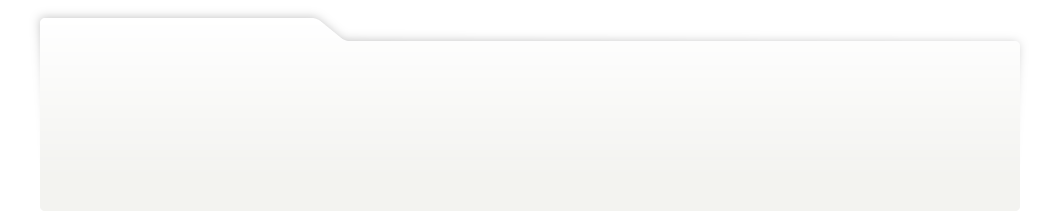
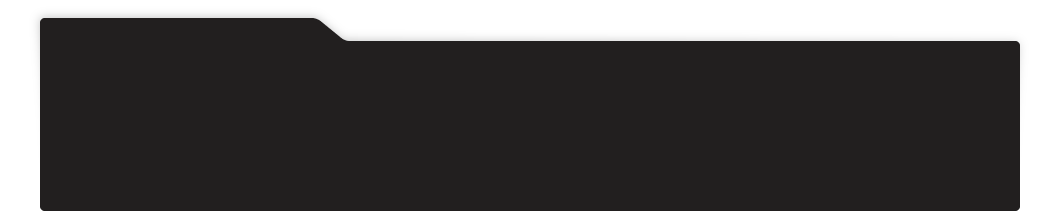
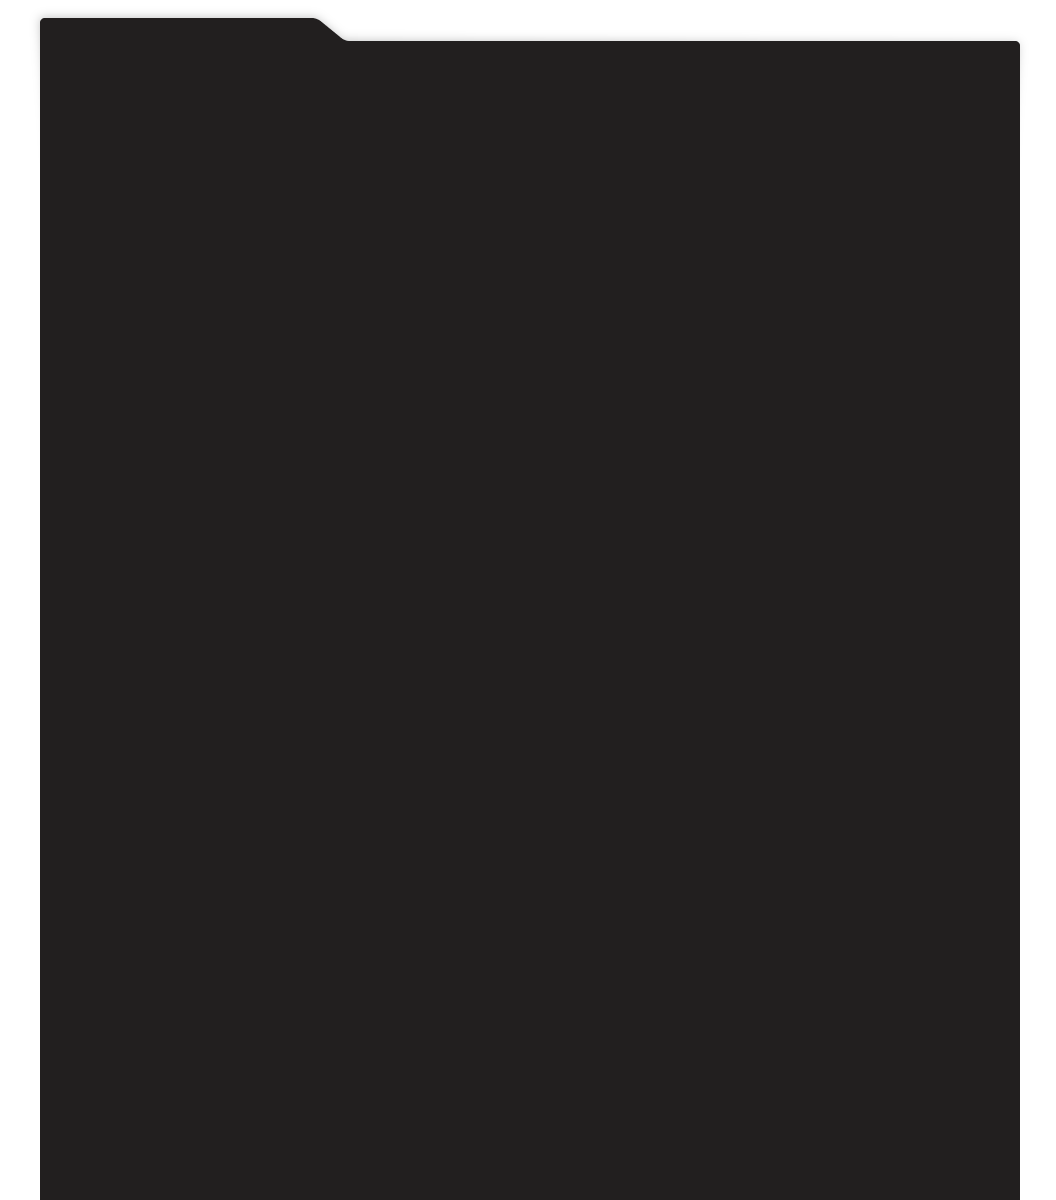
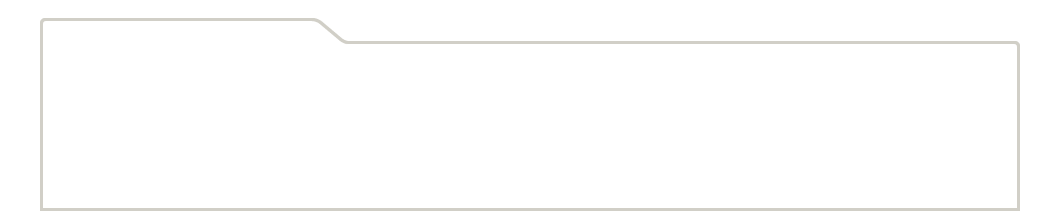
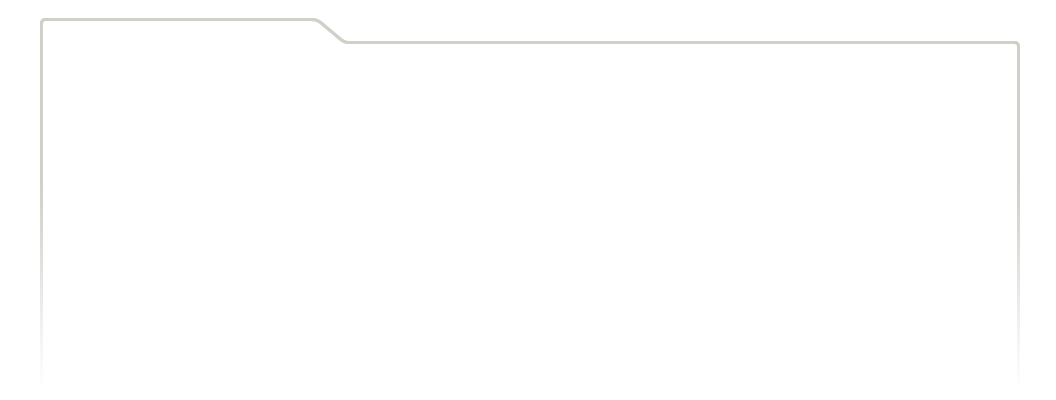
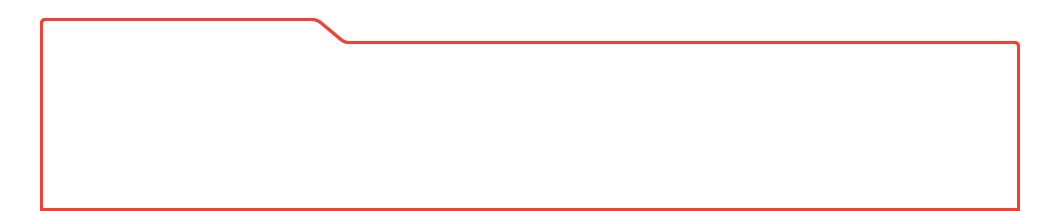
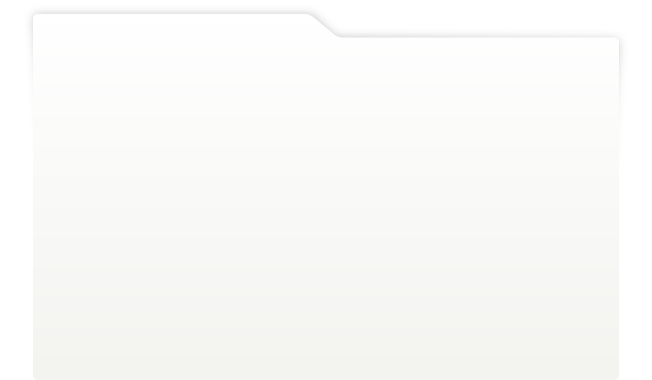
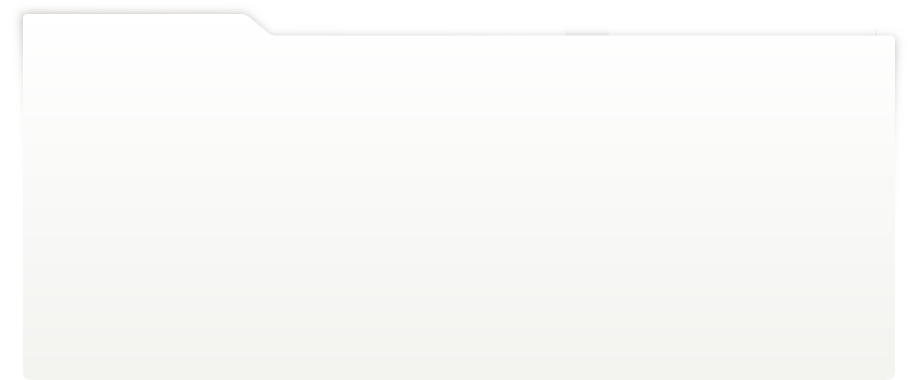
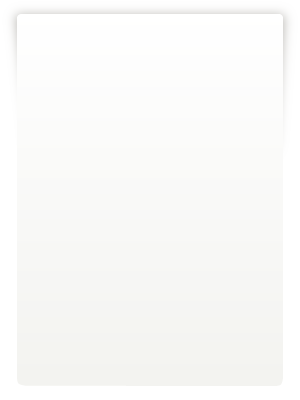
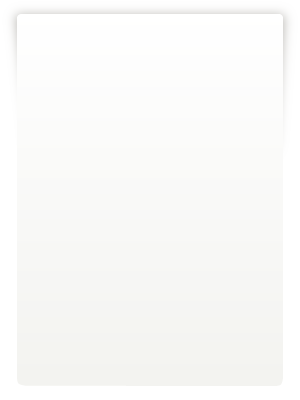
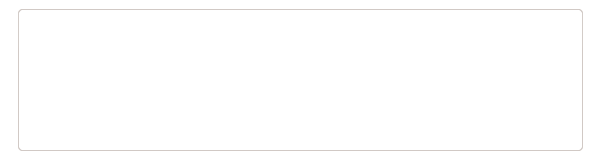
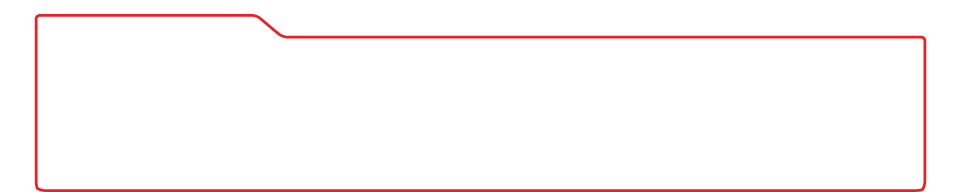
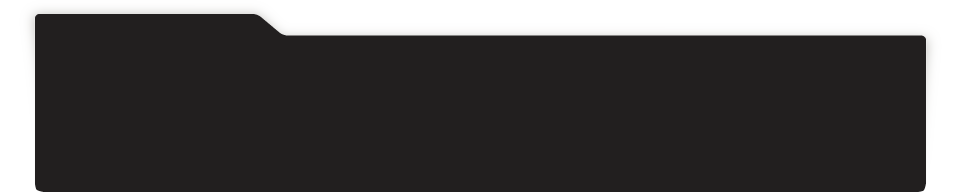
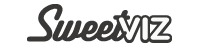
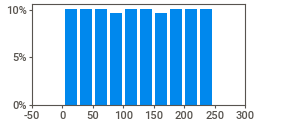
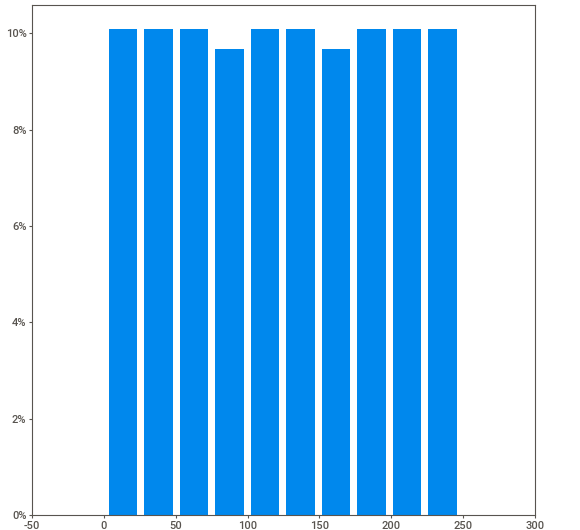
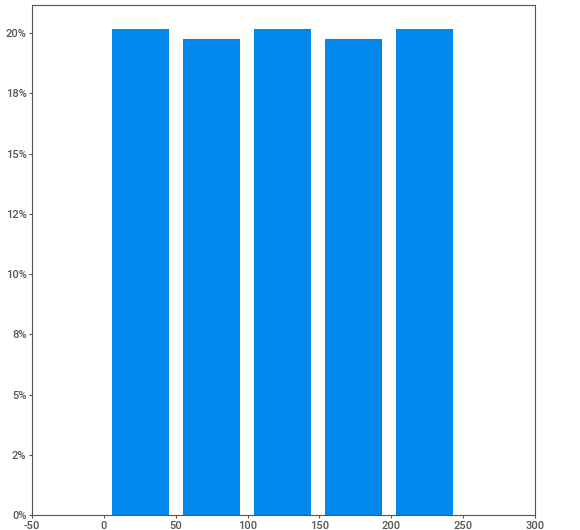
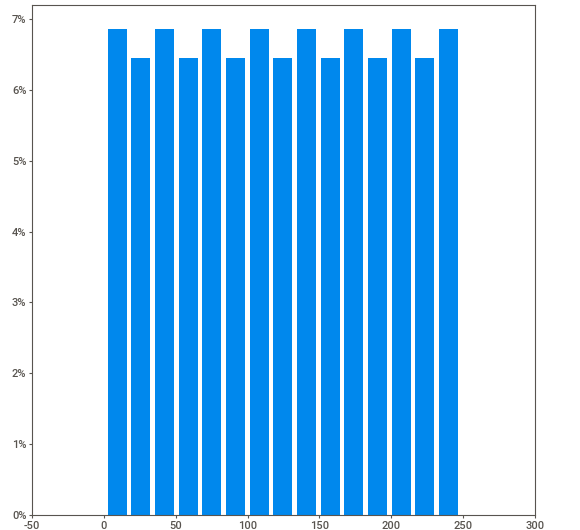
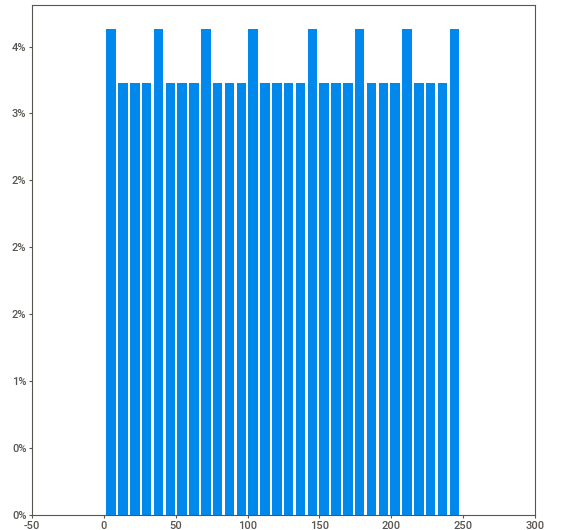
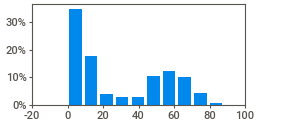
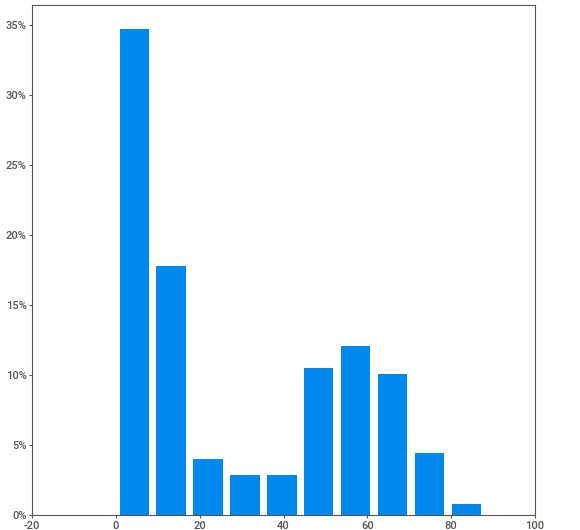
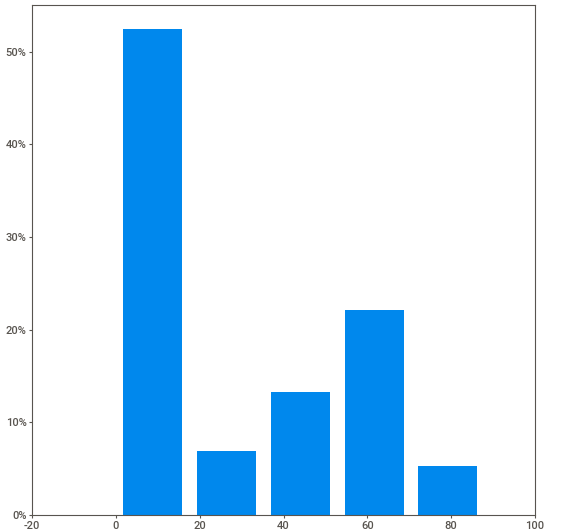
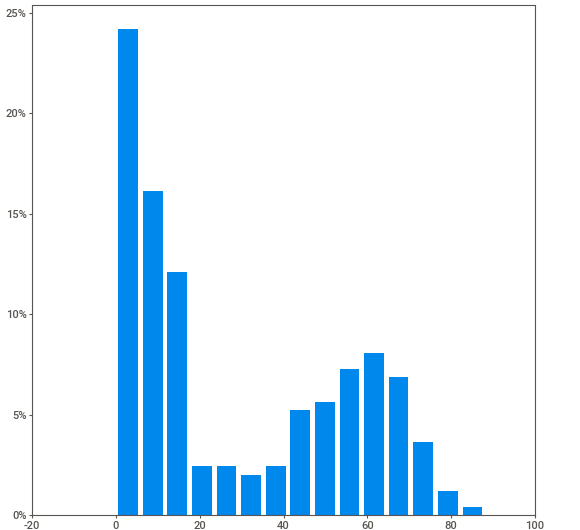
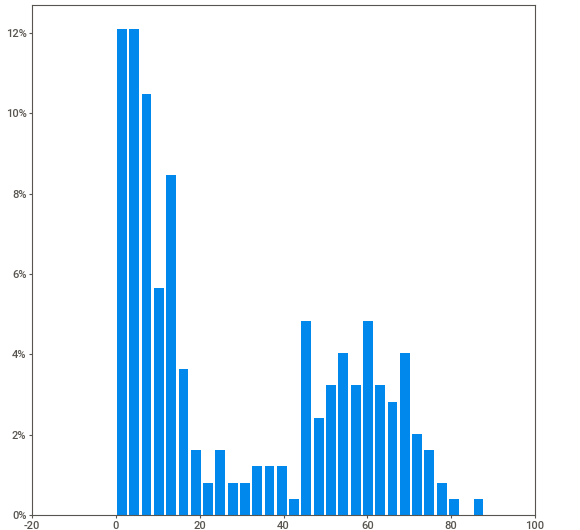
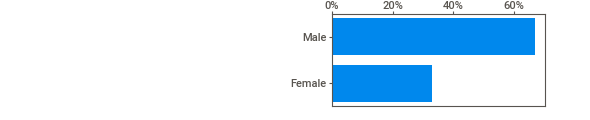
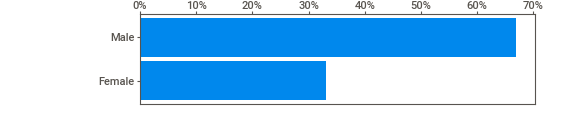
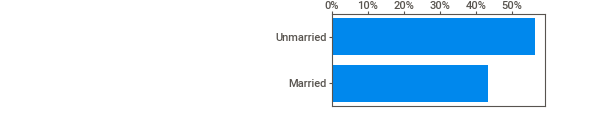
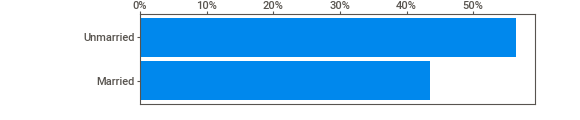
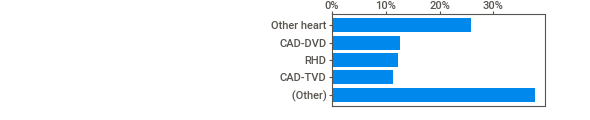
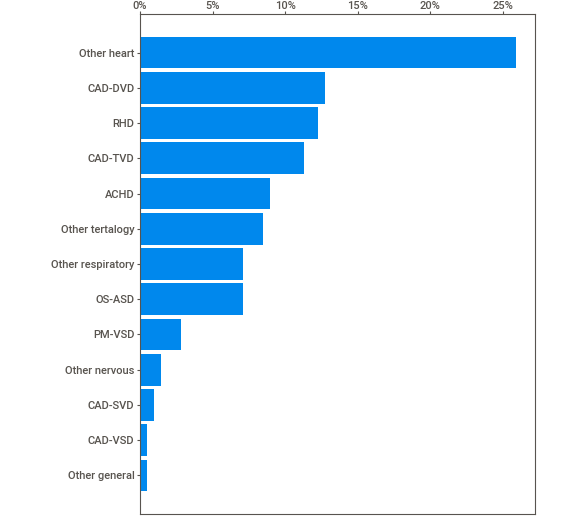
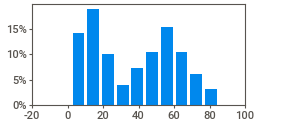
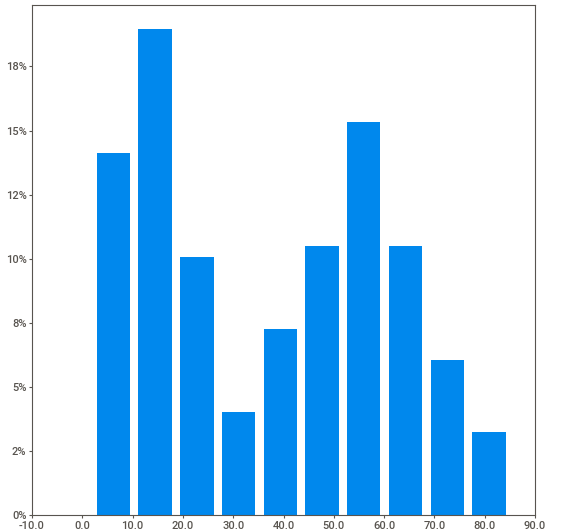
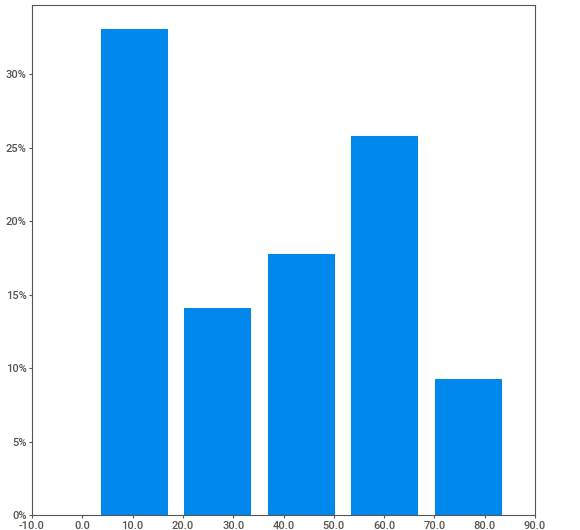
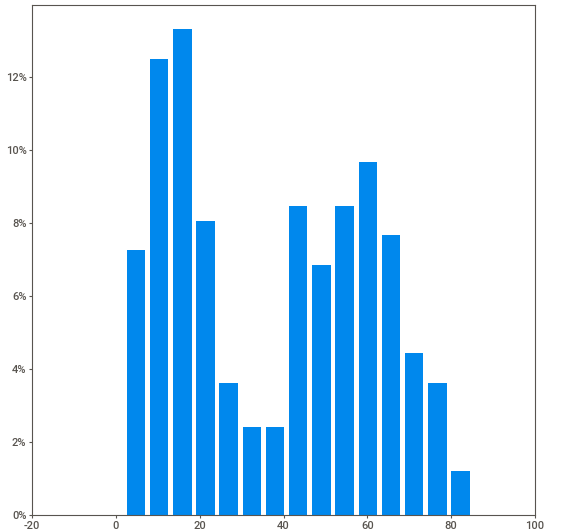
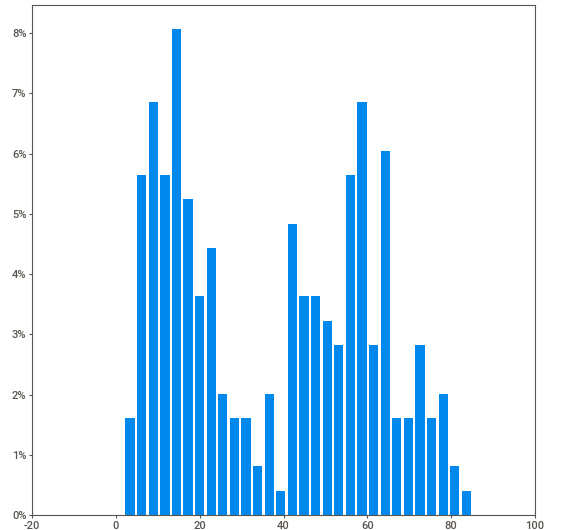
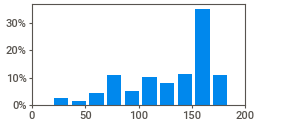
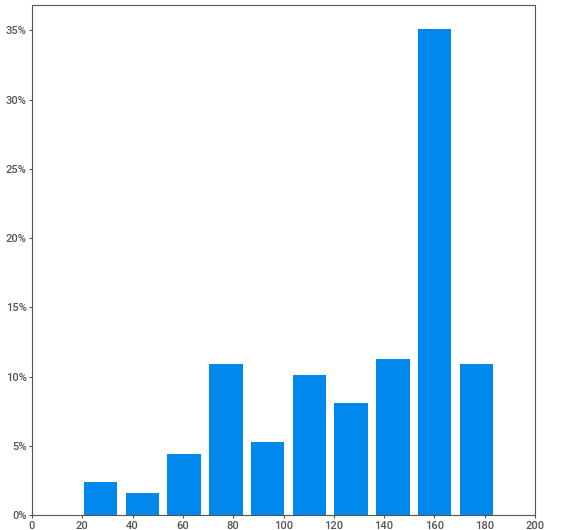
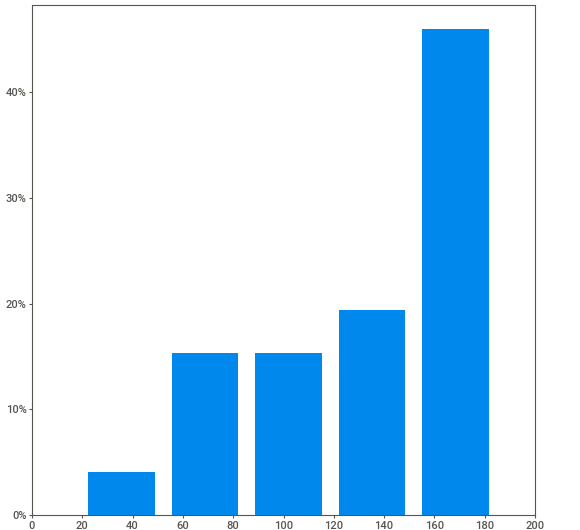
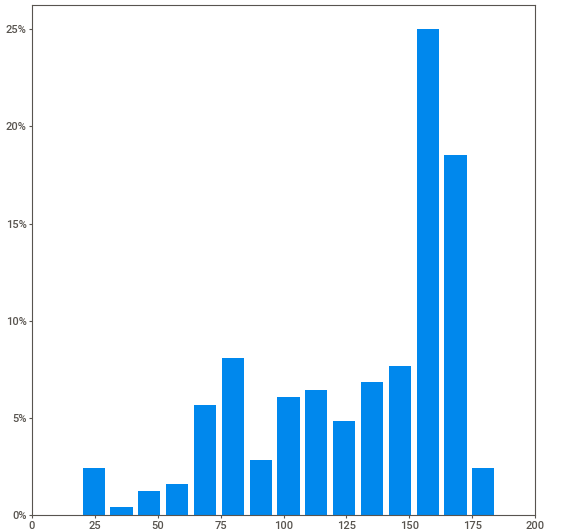
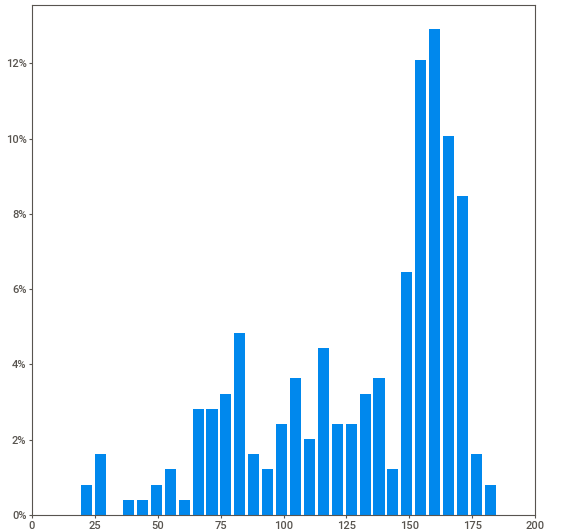
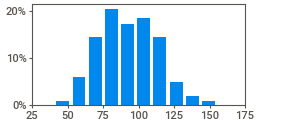
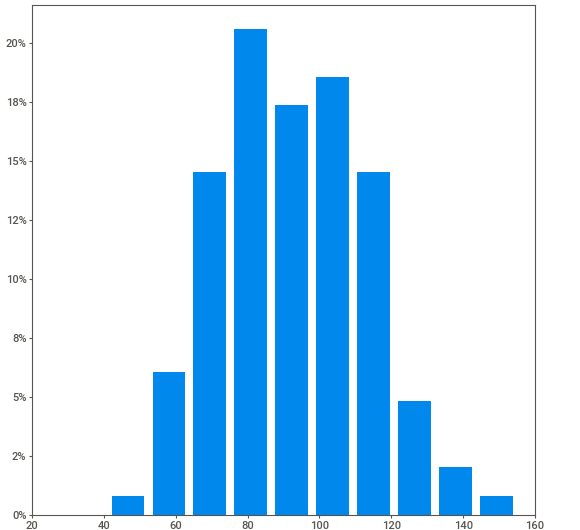
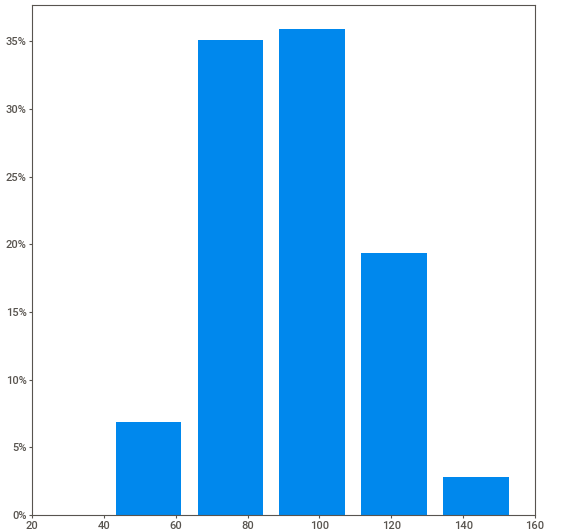
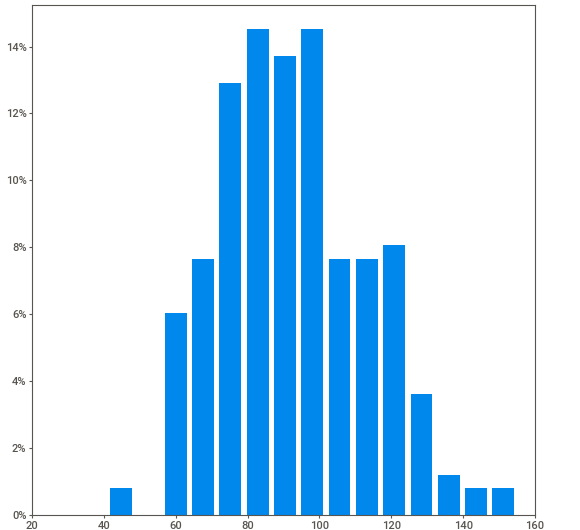
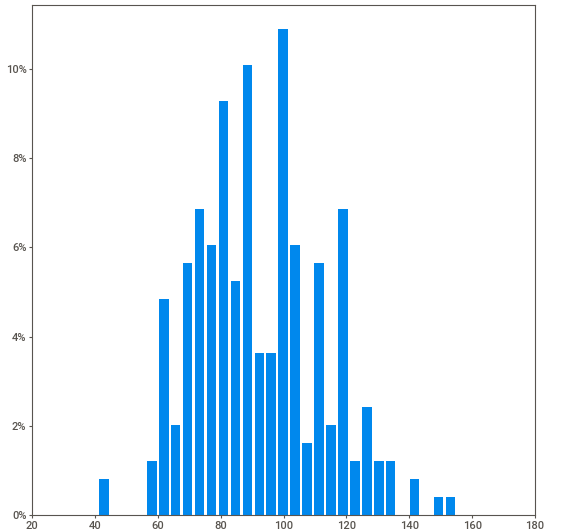
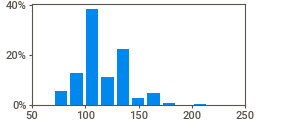
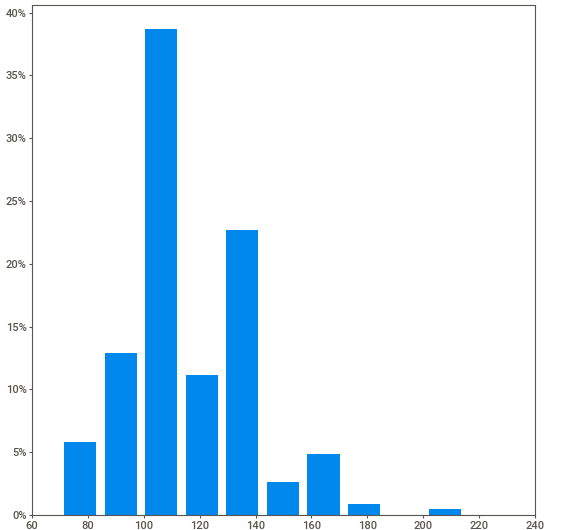
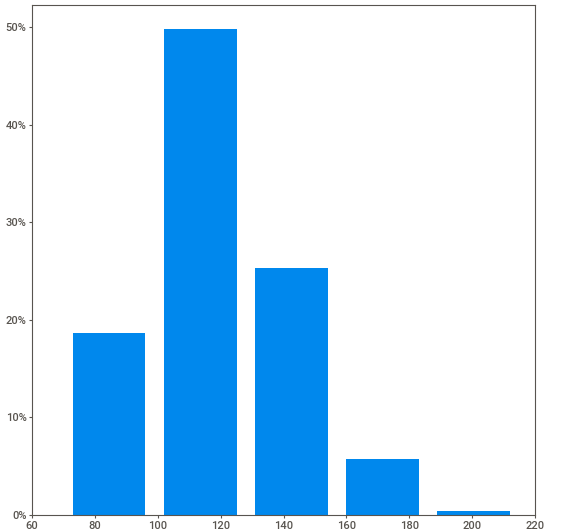
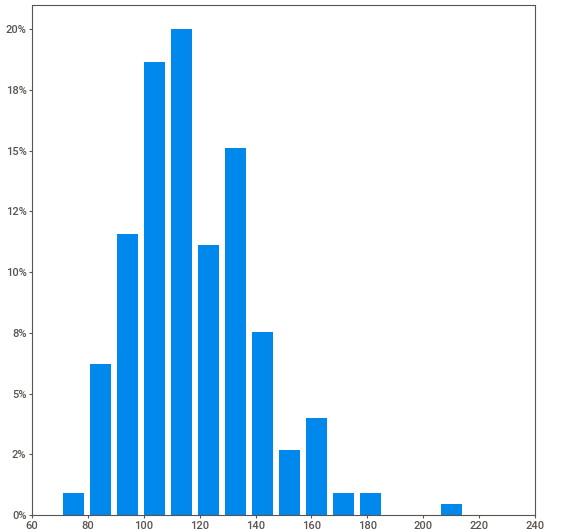
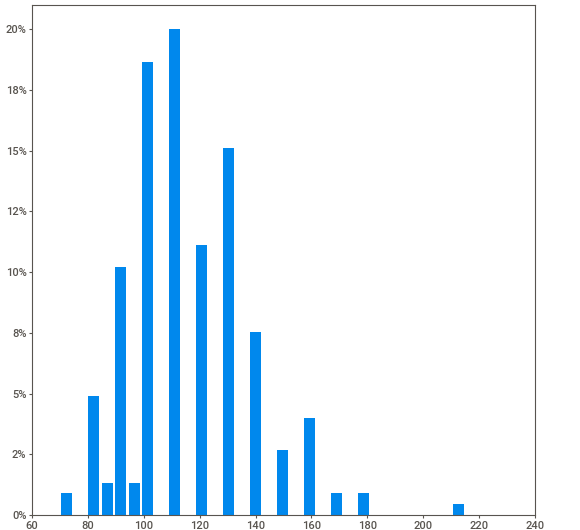
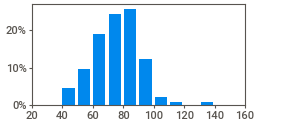
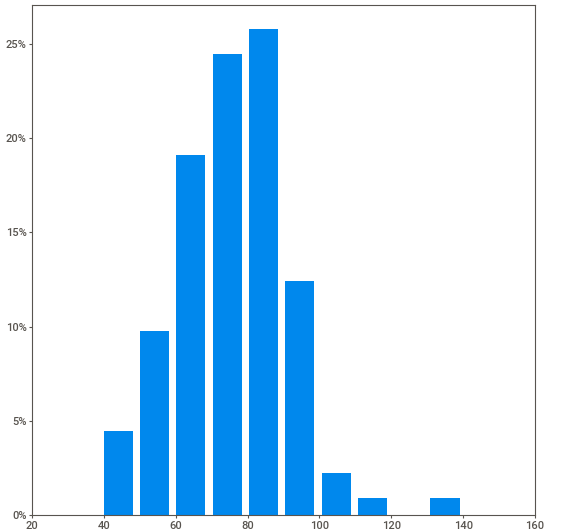
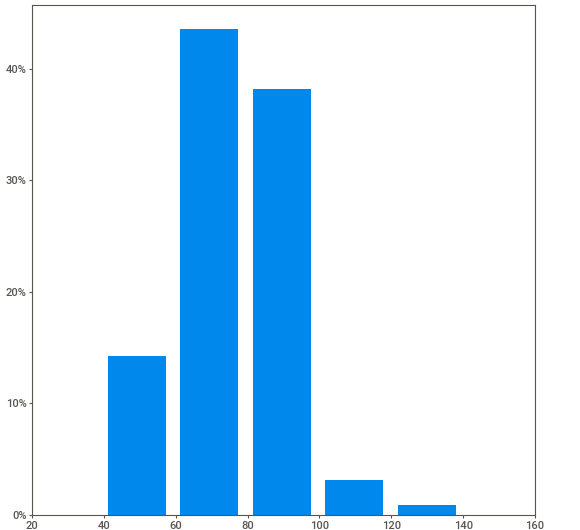
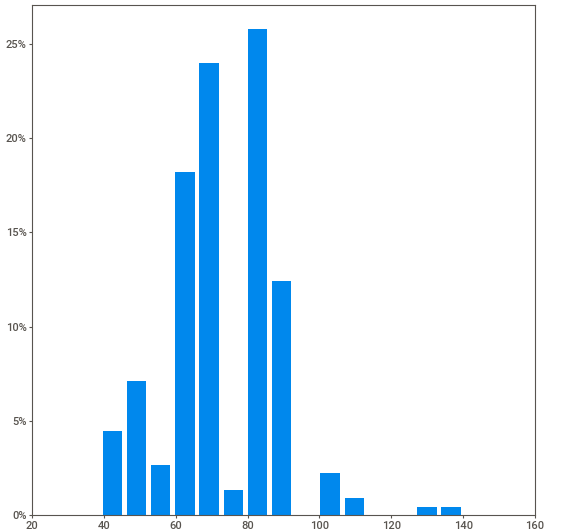
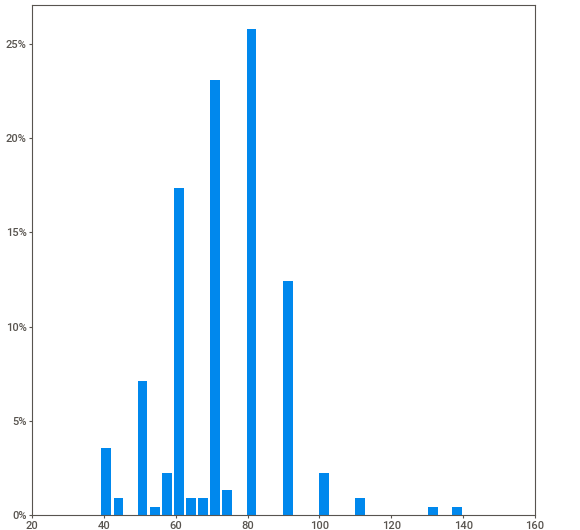
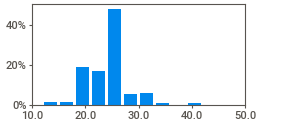
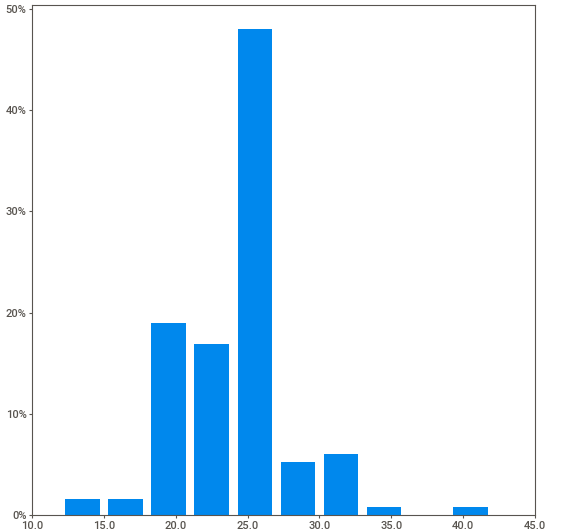
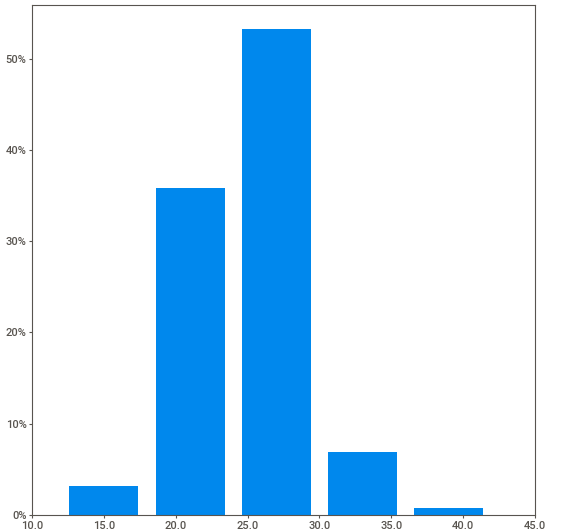
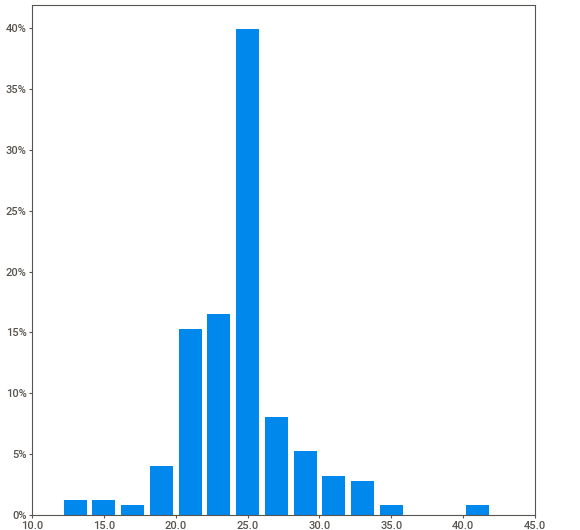
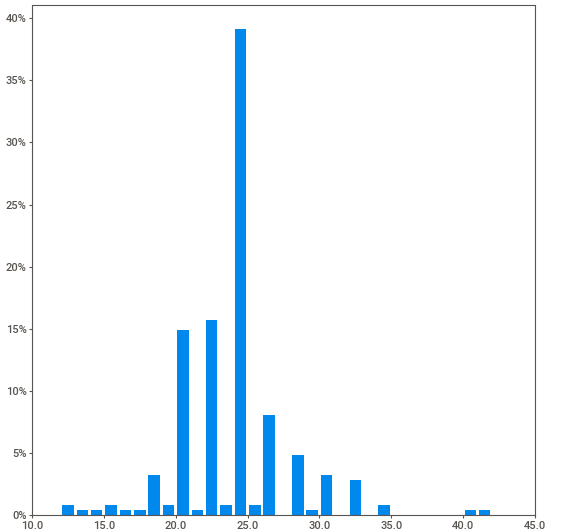
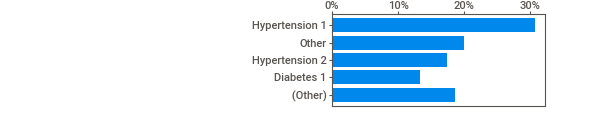
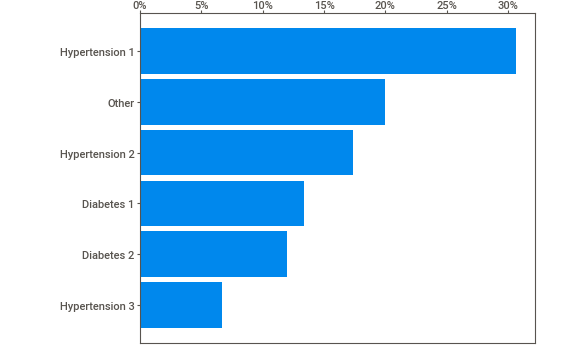
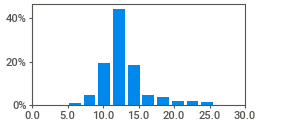
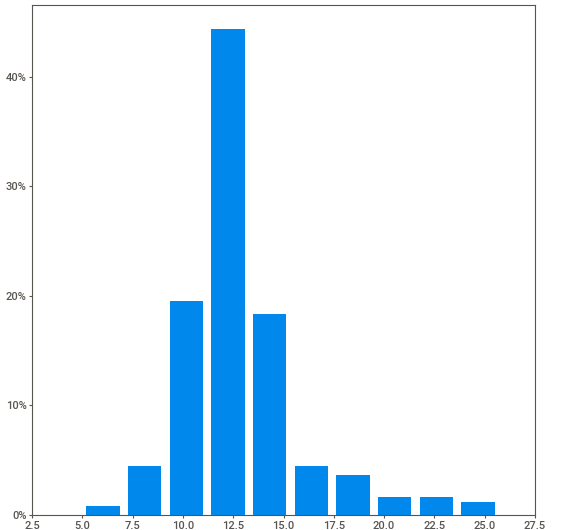
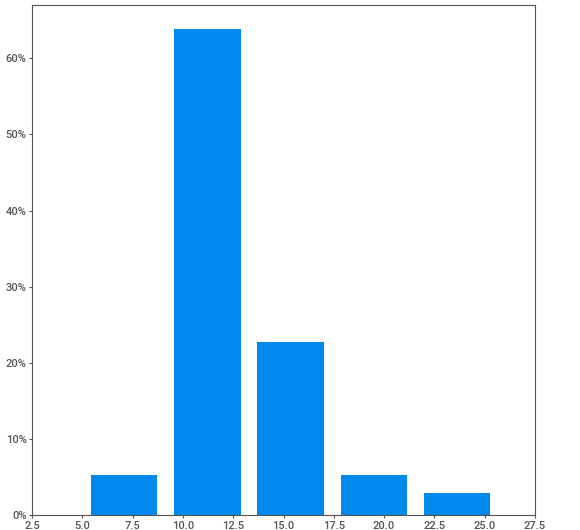
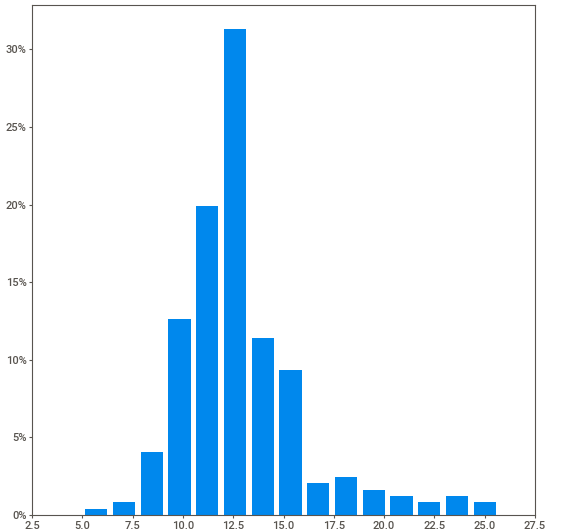
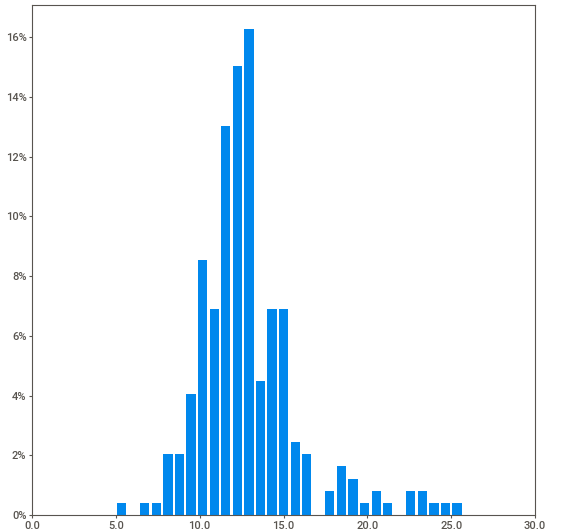
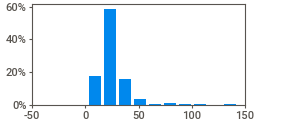
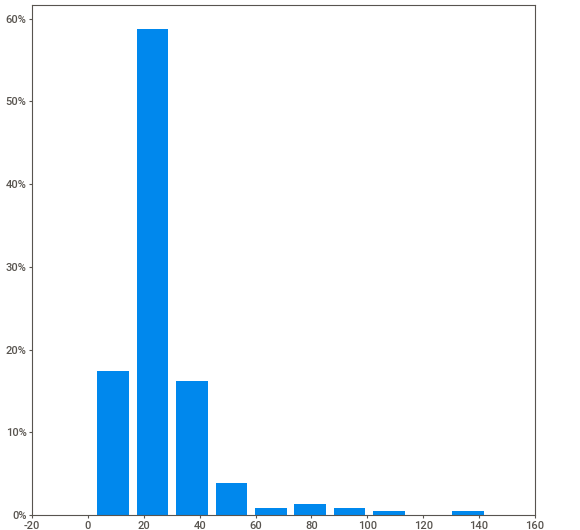
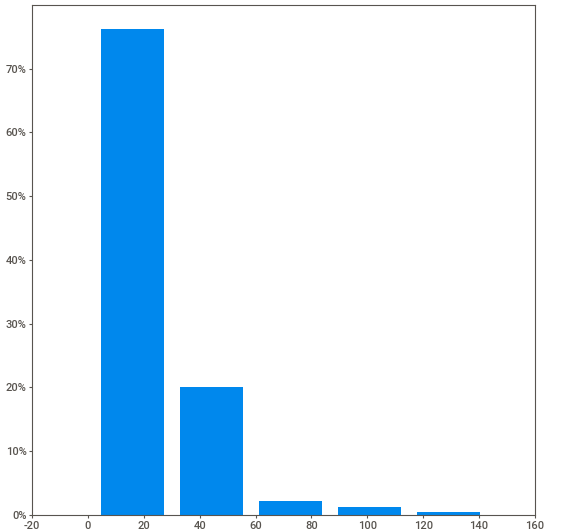
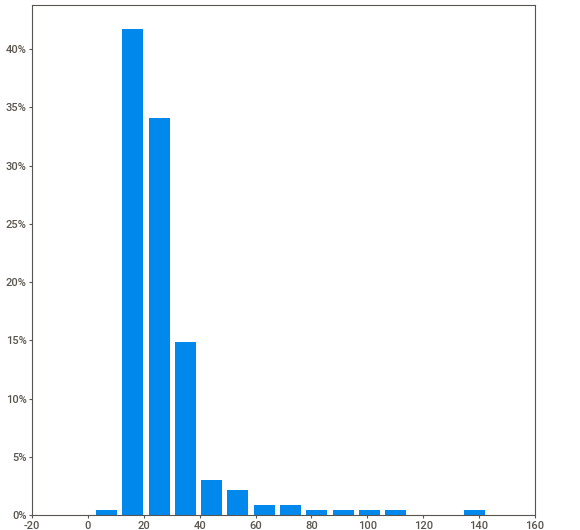
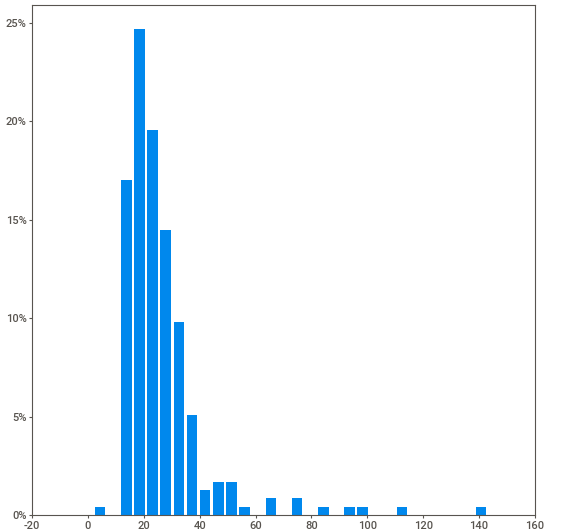
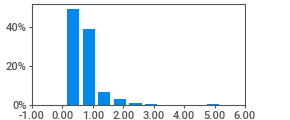
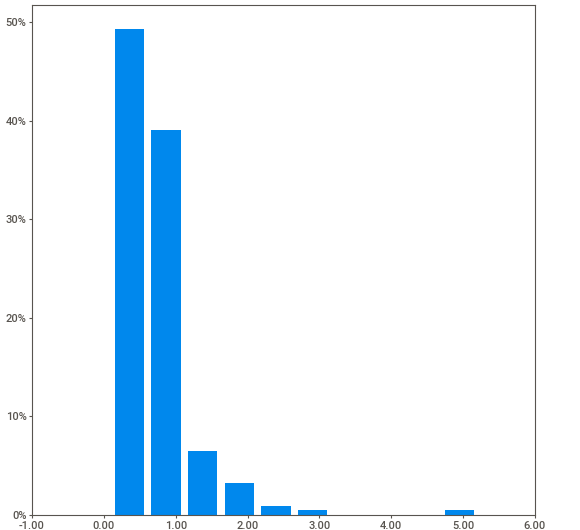
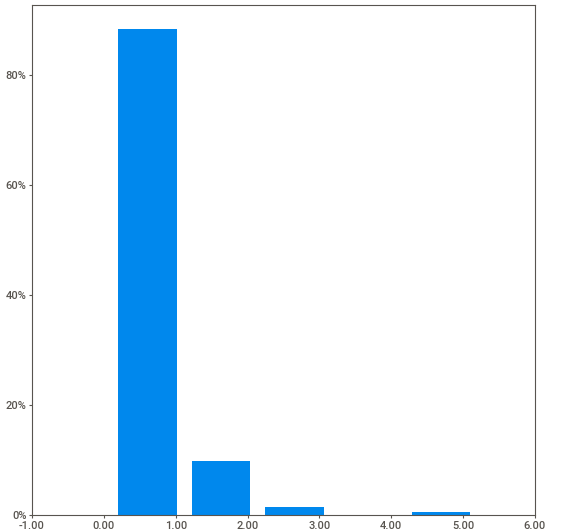
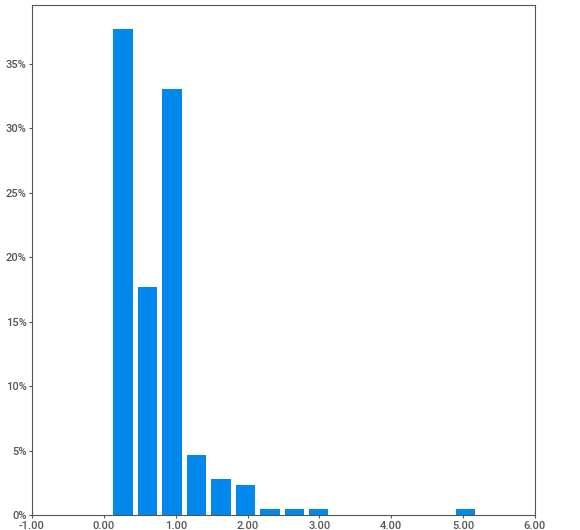
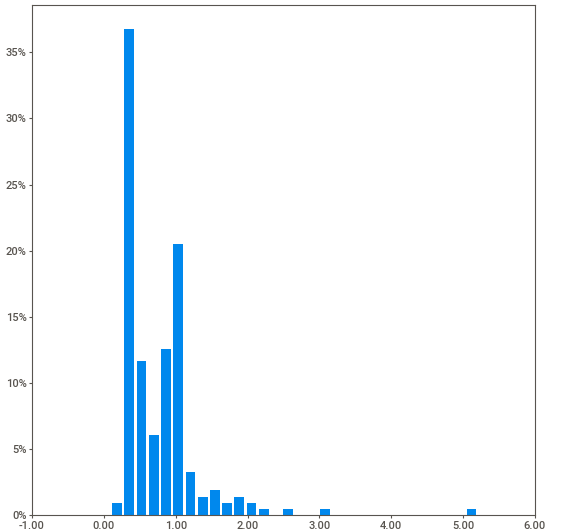
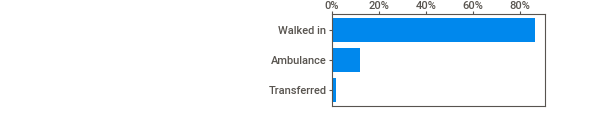
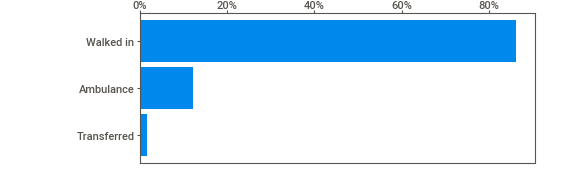
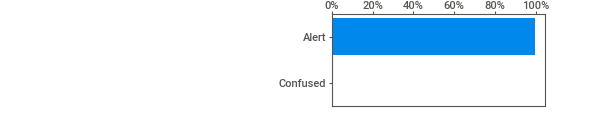
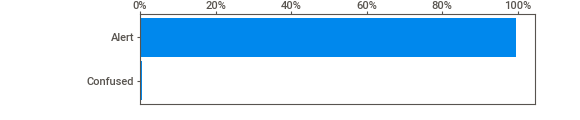
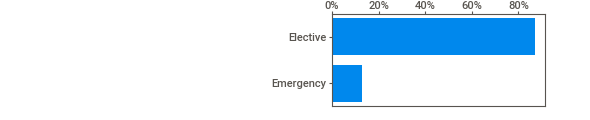
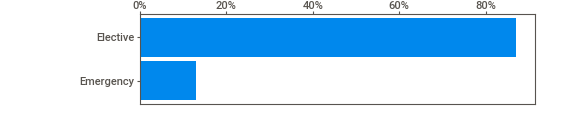
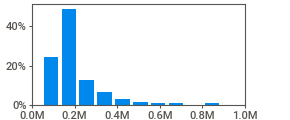
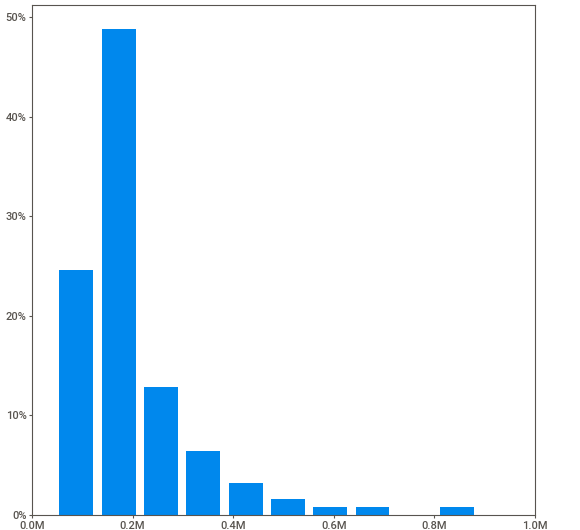
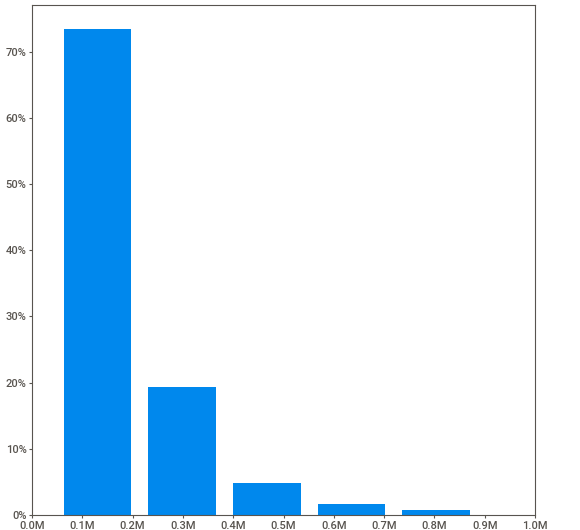
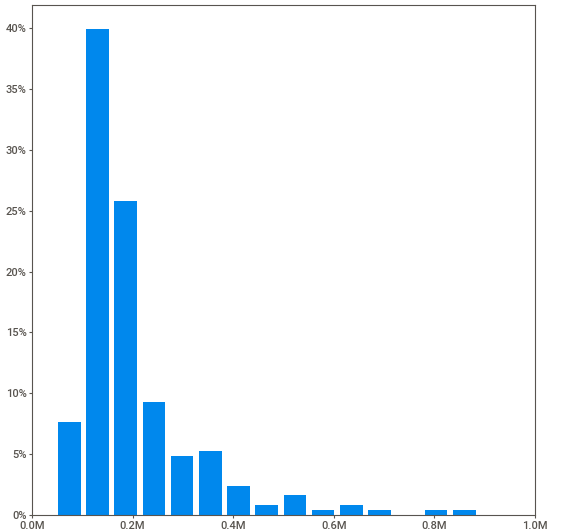
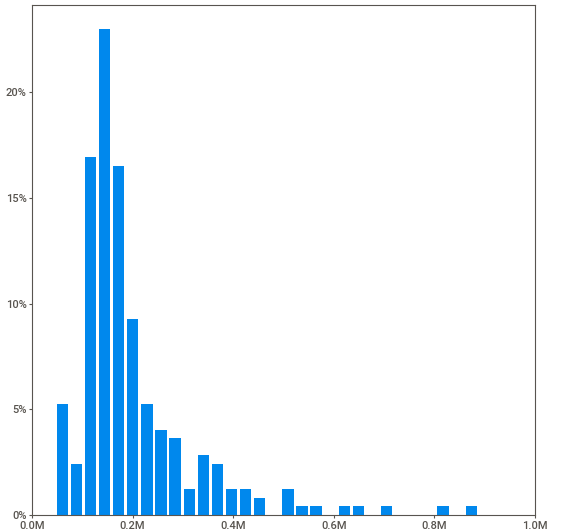
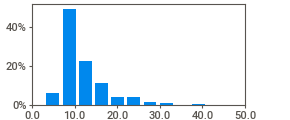
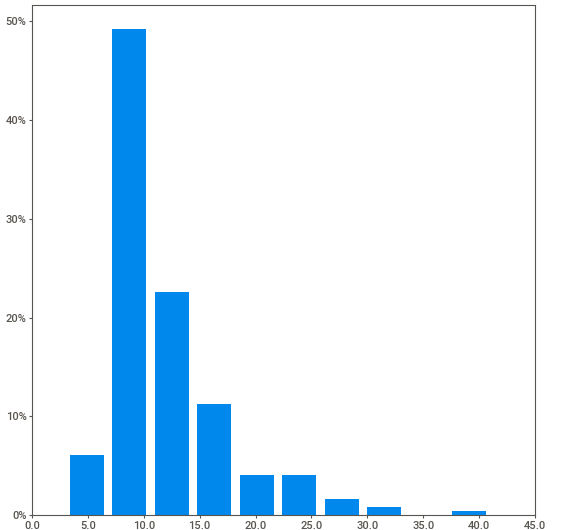
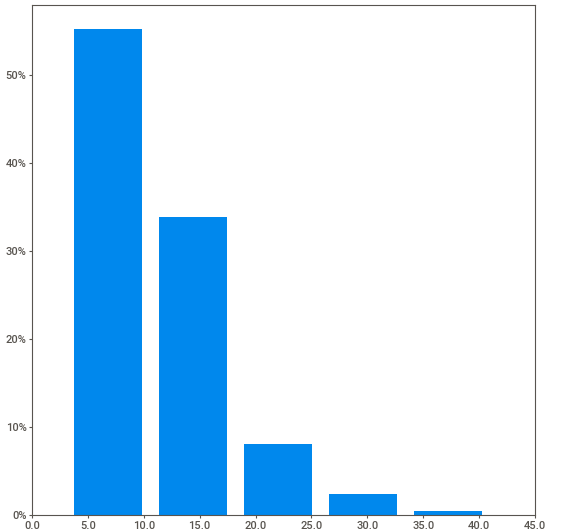
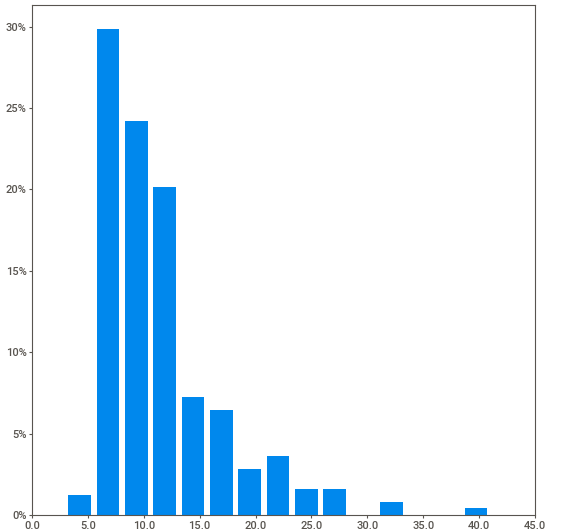
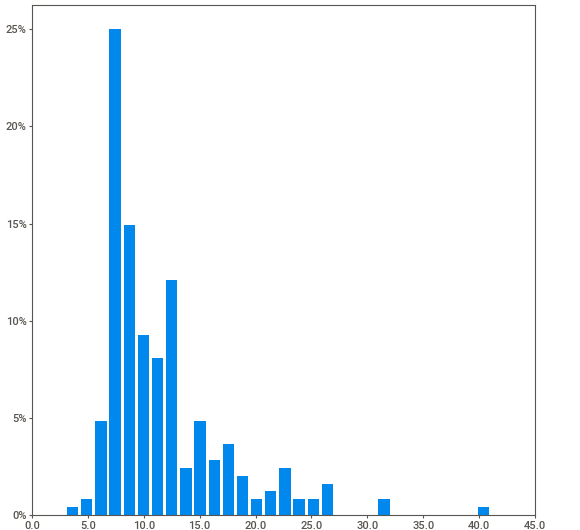
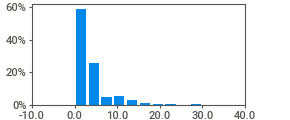
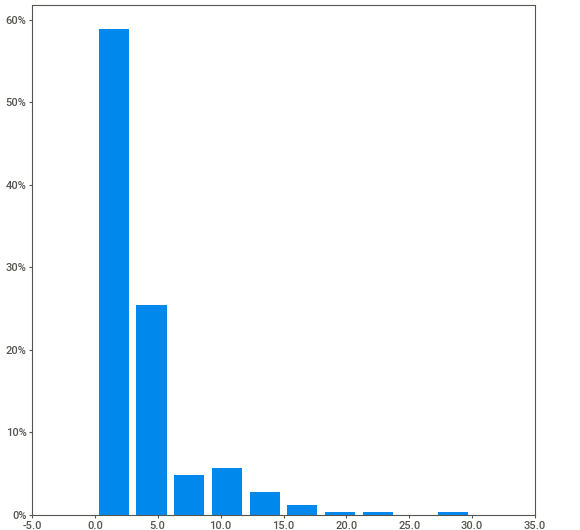
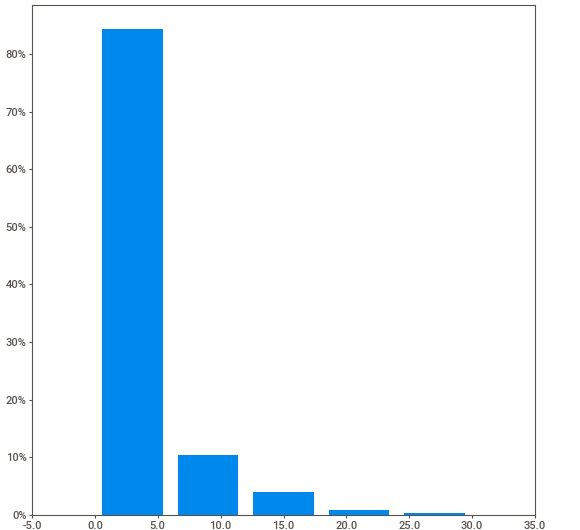
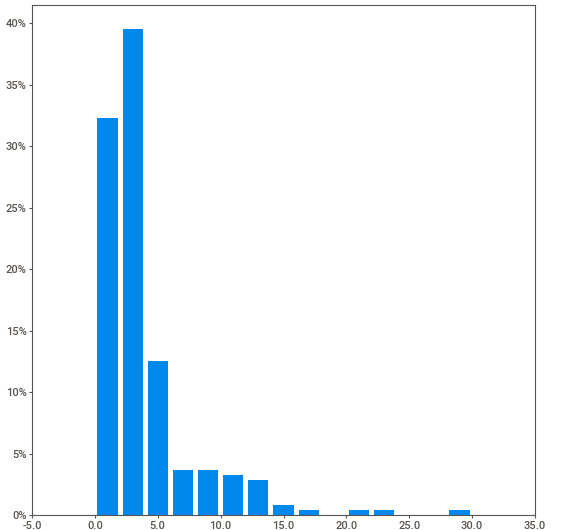
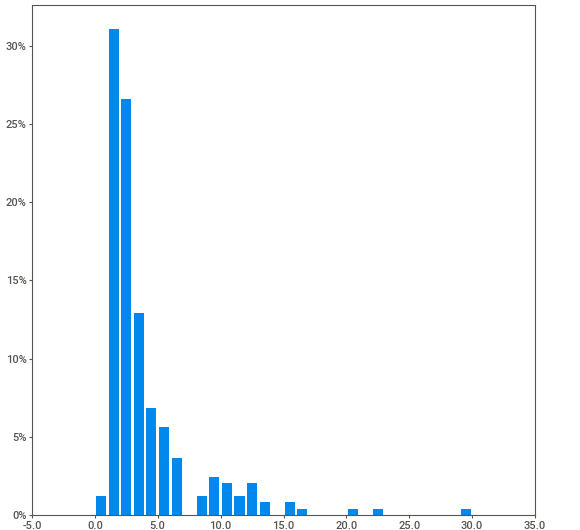
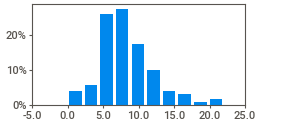
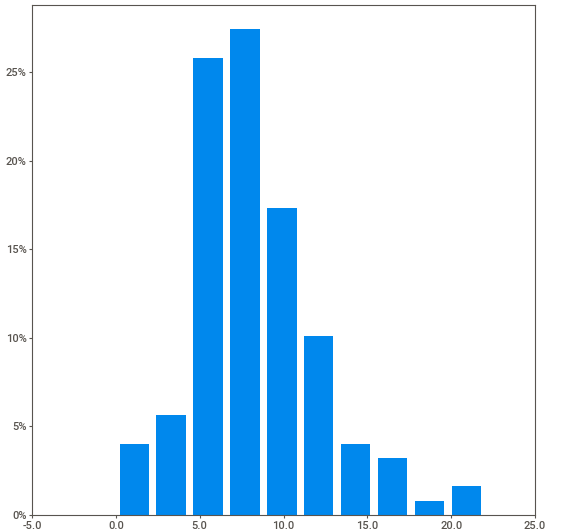
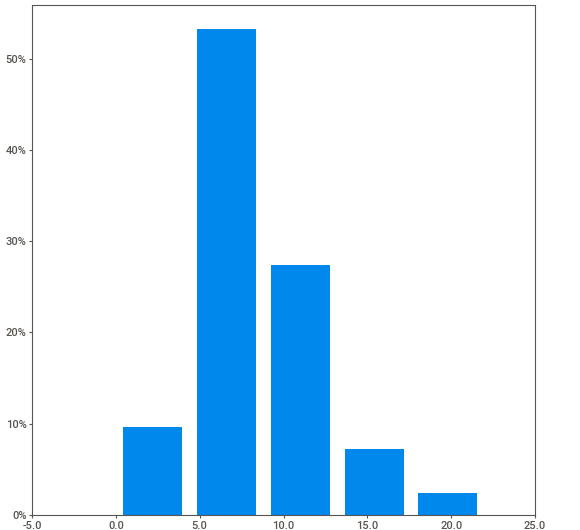
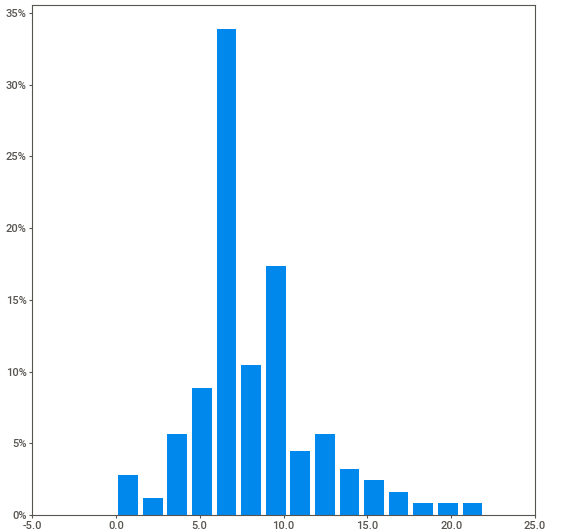
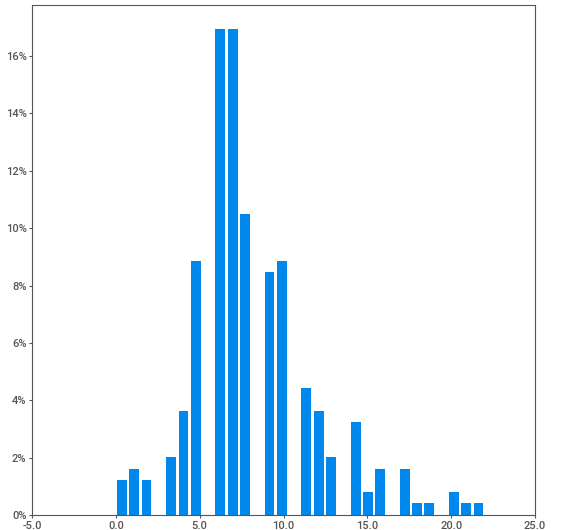
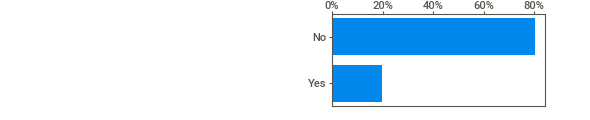
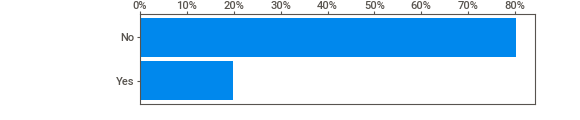
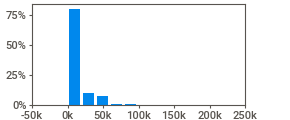
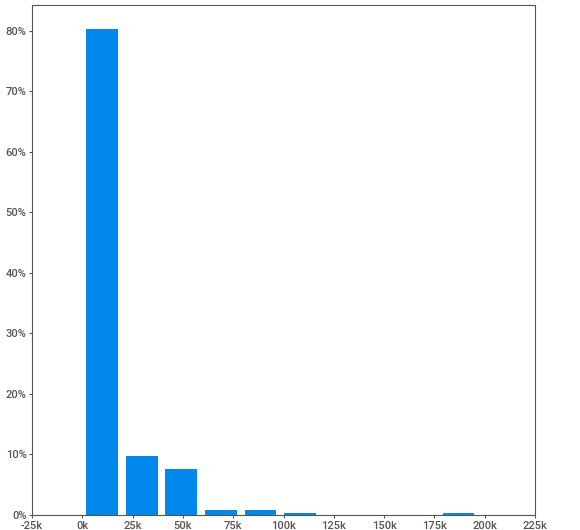
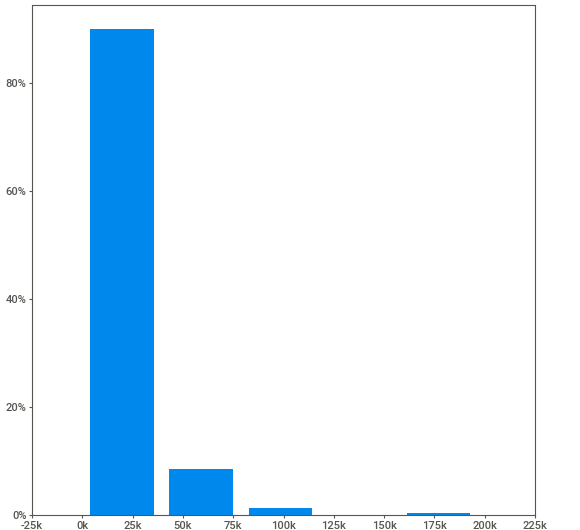
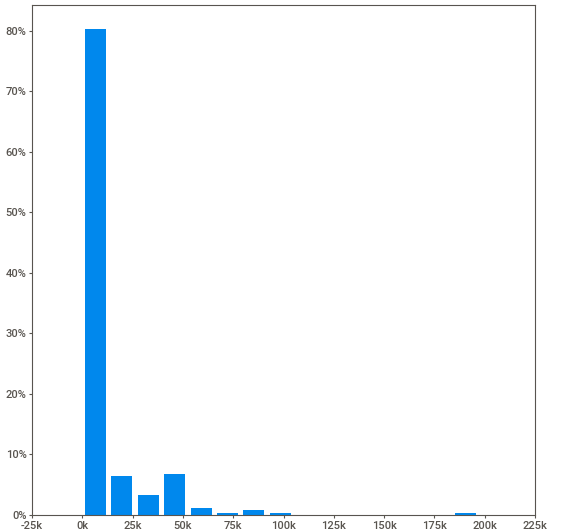
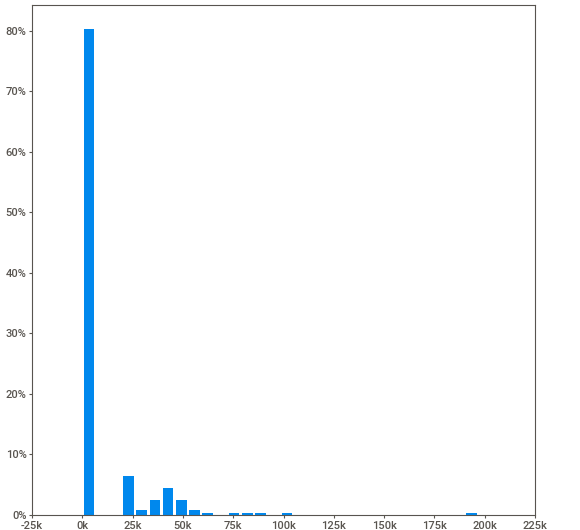
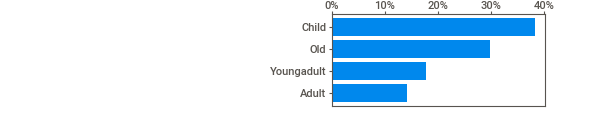
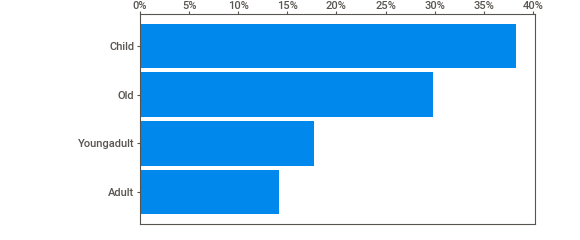
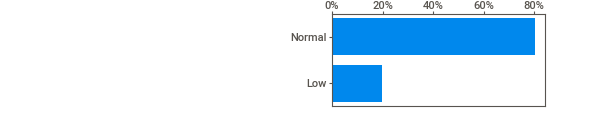
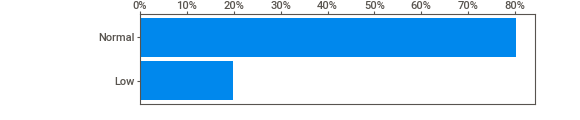
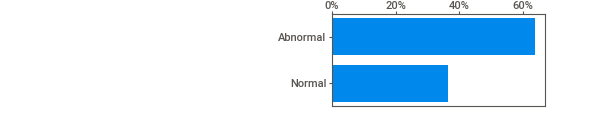
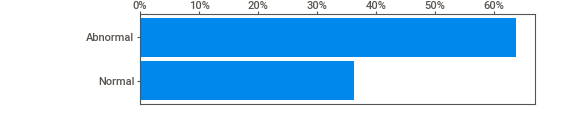
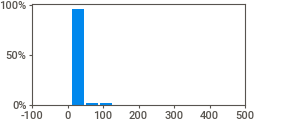
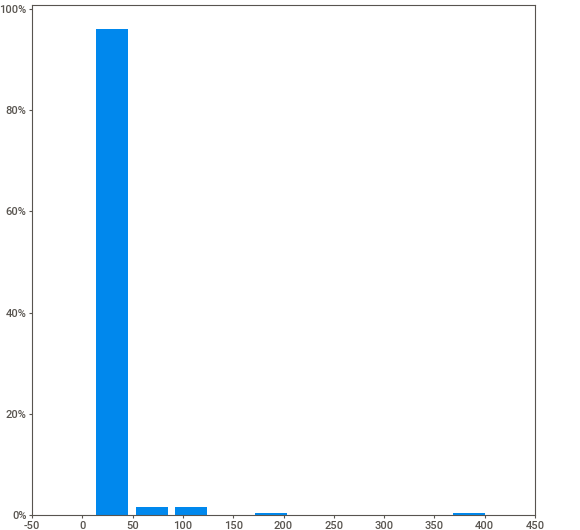
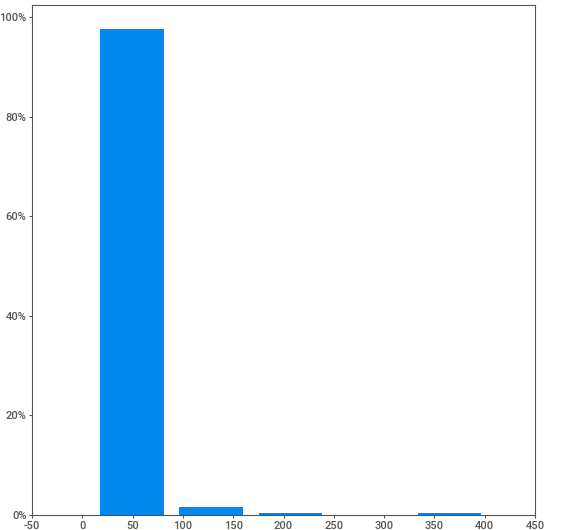
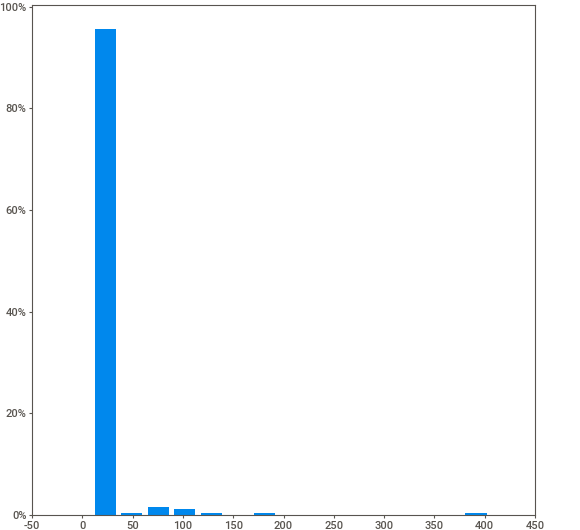
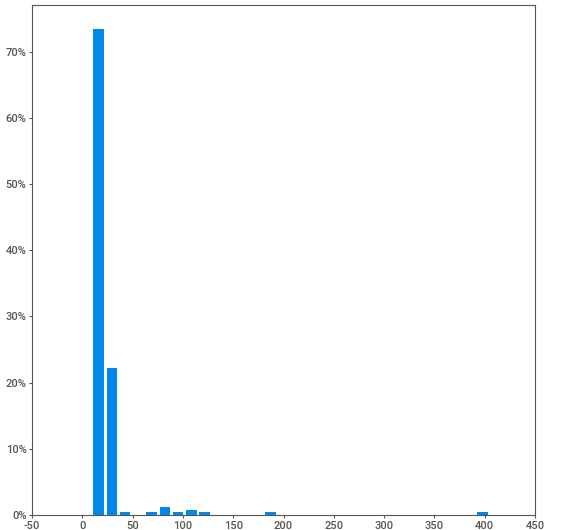
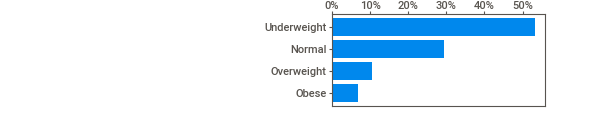
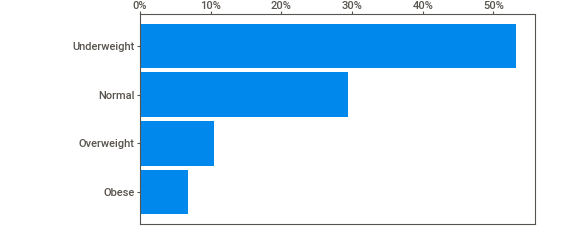
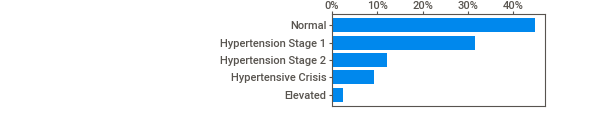
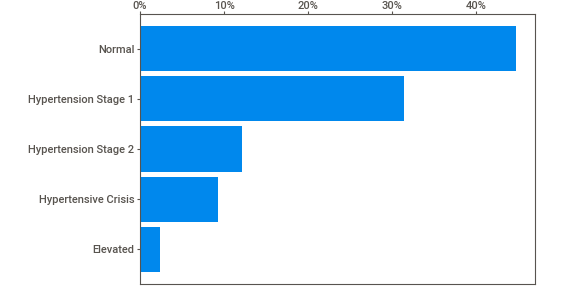
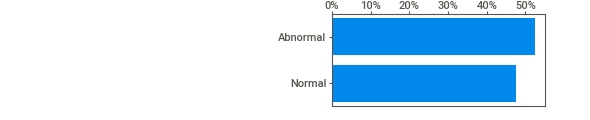
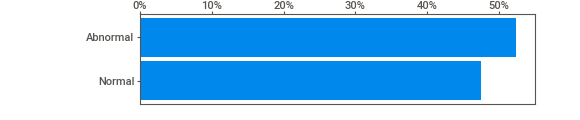
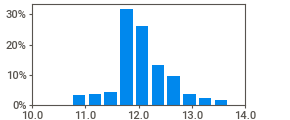
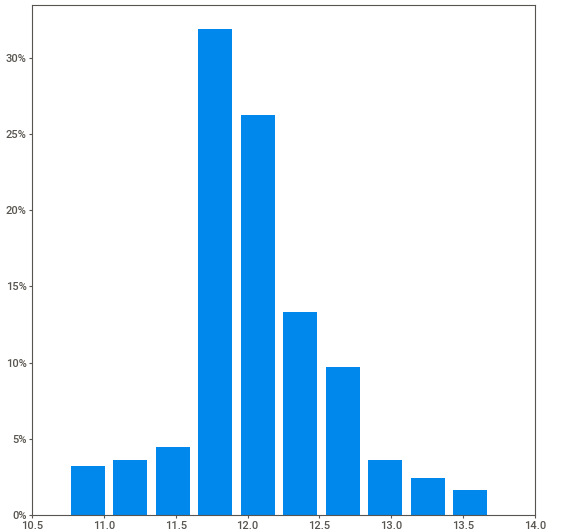
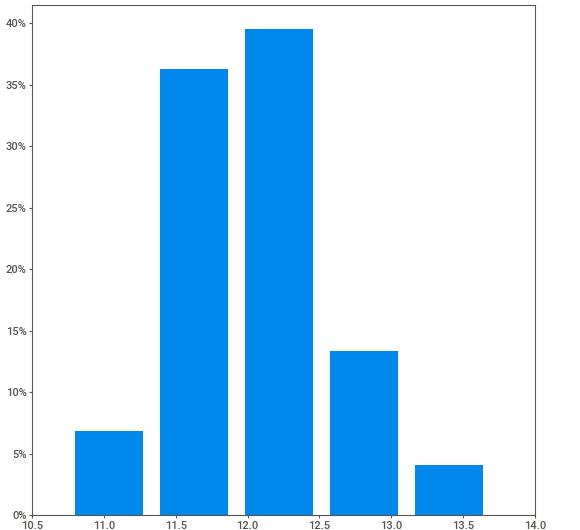
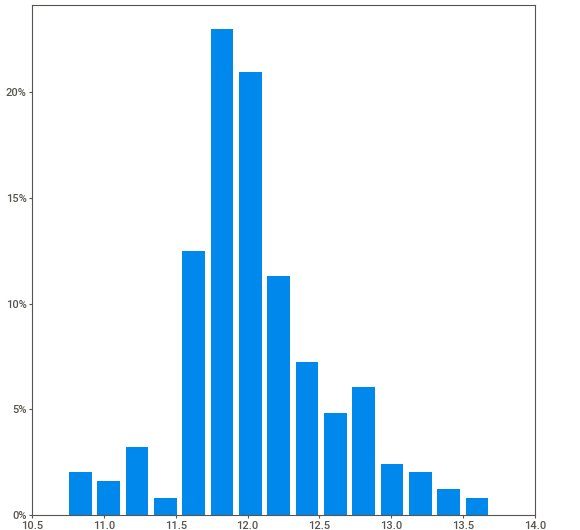
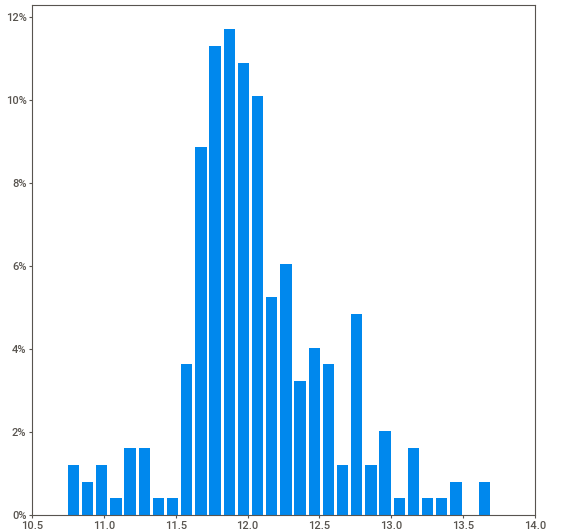
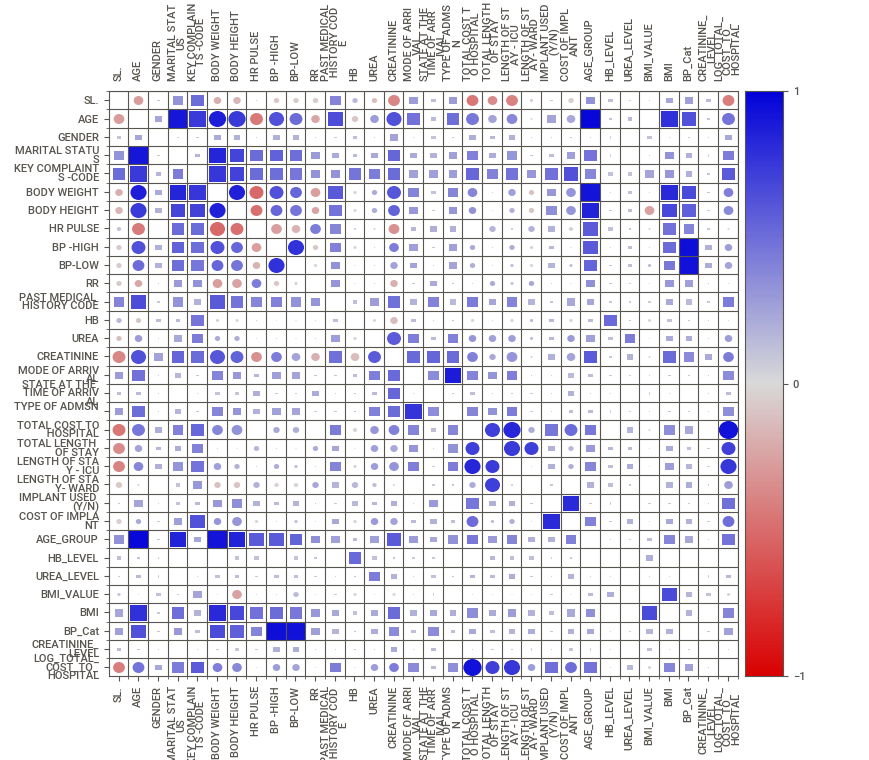
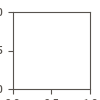

In [16]:
autoEDA = sweetviz.analyze(data)
autoEDA.show_notebook()

## Univariate analysis

In [125]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### Age Group

In [98]:
value_cnt_norm_cal(data, 'AGE_GROUP')

Count  Frequency (%)
AGE_GROUP                       
Child          95      38.306452
Old            74      29.838710
Youngadult     44      17.741935
Adult          35      14.112903

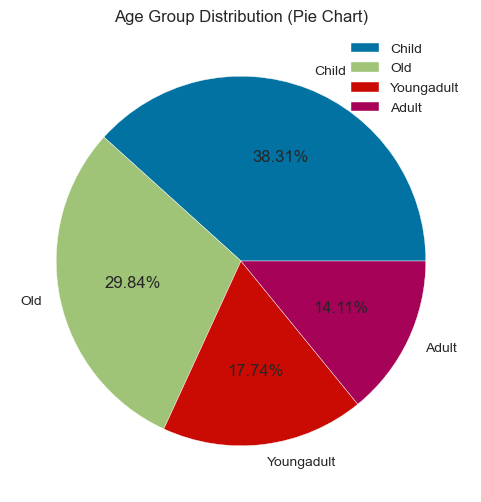

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data['AGE_GROUP'].value_counts(), labels=data['AGE_GROUP'].value_counts().index, autopct='%1.2f%%')
plt.title('Age Group Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [100]:
data.groupby('AGE_GROUP')['TOTAL COST TO HOSPITAL'].mean()

AGE_GROUP
Adult         227254.304286
Child         153206.494105
Old           268048.069189
Youngadult    157711.618182
Name: TOTAL COST TO HOSPITAL, dtype: float64

### Marital Status

In [101]:
value_cnt_norm_cal(data, 'MARITAL STATUS')

Count  Frequency (%)
MARITAL STATUS                      
Unmarried         140      56.451613
Married           108      43.548387

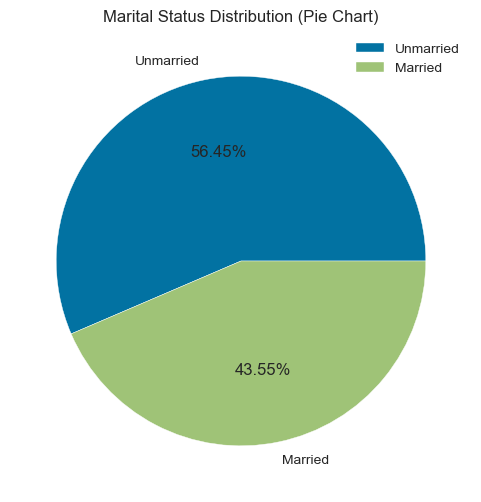

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data['MARITAL STATUS'].value_counts(), labels=data['MARITAL STATUS'].value_counts().index, autopct='%1.2f%%')
plt.title('Marital Status Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [103]:
data.groupby('MARITAL STATUS')['TOTAL COST TO HOSPITAL'].mean()

MARITAL STATUS
Married      250975.247315
Unmarried    158414.708571
Name: TOTAL COST TO HOSPITAL, dtype: float64

### Gender

In [104]:
value_cnt_norm_cal(data, 'GENDER')

Count  Frequency (%)
GENDER                      
Male      166      66.935484
Female     82      33.064516

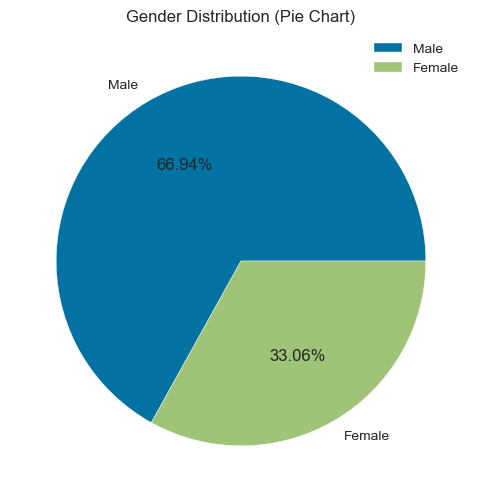

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data['GENDER'].value_counts(), labels=data['GENDER'].value_counts().index, autopct='%1.2f%%')
plt.title('Gender Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [56]:
data.groupby('GENDER')['TOTAL COST TO HOSPITAL'].mean()

GENDER
Female    172111.923902
Male      211868.723795
Name: TOTAL COST TO HOSPITAL, dtype: float64

### Key Complaints Code

In [23]:
value_cnt_norm_cal(data, 'KEY COMPLAINTS -CODE')

Count  Frequency (%)
KEY COMPLAINTS -CODE                      
Other heart              55      25.943396
CAD-DVD                  27      12.735849
RHD                      26      12.264151
CAD-TVD                  24      11.320755
ACHD                     19       8.962264
Other tertalogy          18       8.490566
Other respiratory        15       7.075472
OS-ASD                   15       7.075472
PM-VSD                    6       2.830189
Other nervous             3       1.415094
CAD-SVD                   2       0.943396
CAD-VSD                   1       0.471698
Other general             1       0.471698

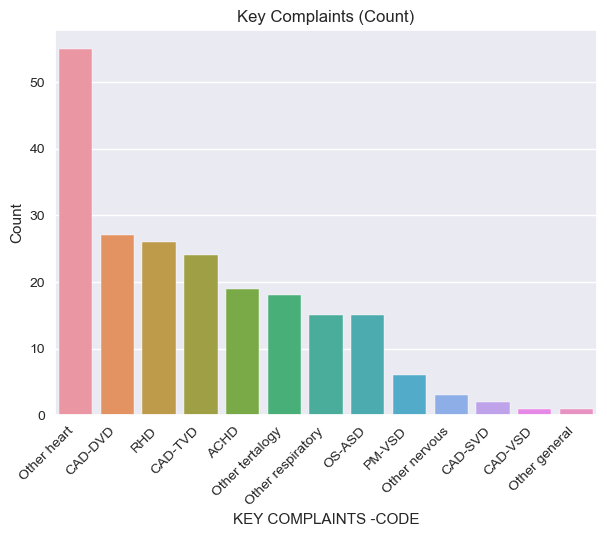

In [24]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=value_cnt_norm_cal(data,'KEY COMPLAINTS -CODE').index, y=value_cnt_norm_cal(data,'KEY COMPLAINTS -CODE')['Count'])
plt.title('Key Complaints (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

### Past Medical History

In [25]:
value_cnt_norm_cal(data, 'PAST MEDICAL HISTORY CODE')

Count  Frequency (%)
PAST MEDICAL HISTORY CODE                      
Hypertension 1                23      30.666667
Other                         15      20.000000
Hypertension 2                13      17.333333
Diabetes 1                    10      13.333333
Diabetes 2                     9      12.000000
Hypertension 3                 5       6.666667

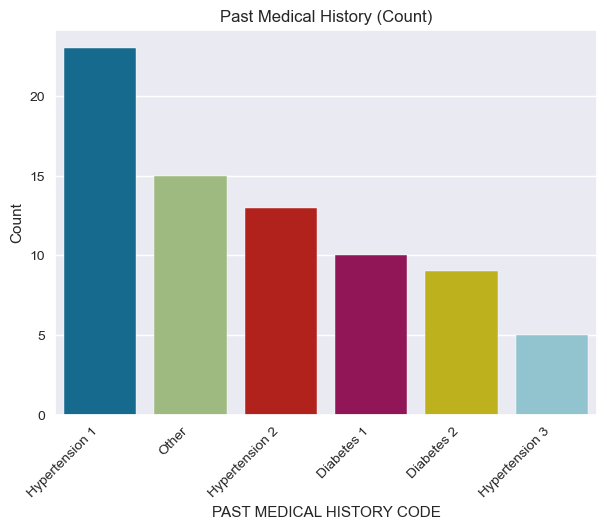

In [25]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=value_cnt_norm_cal(data,'PAST MEDICAL HISTORY CODE').index, y=value_cnt_norm_cal(data,'PAST MEDICAL HISTORY CODE')['Count'])
plt.title('Past Medical History (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

### Blood Pressure Categories

In [27]:
value_cnt_norm_cal(data, 'BP_Cat')

Count  Frequency (%)
BP_Cat                                    
Normal                  111      44.758065
Hypertension Stage 1     78      31.451613
Hypertension Stage 2     30      12.096774
Hypertensive Crisis      23       9.274194
Elevated                  6       2.419355

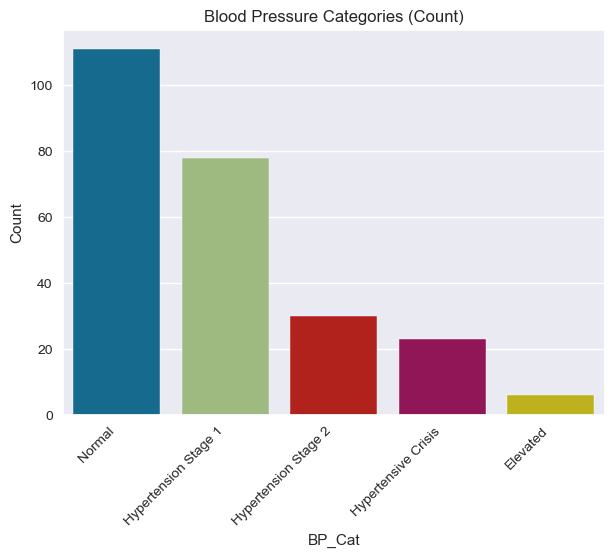

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=value_cnt_norm_cal(data,'BP_Cat').index, y=value_cnt_norm_cal(data,'BP_Cat')['Count'])
plt.title('Blood Pressure Categories (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

### BMI Categories

In [67]:
value_cnt_norm_cal(data, 'BMI')

Count  Frequency (%)
BMI                              
Underweight    132      53.225806
Normal          73      29.435484
Overweight      26      10.483871
Obese           17       6.854839

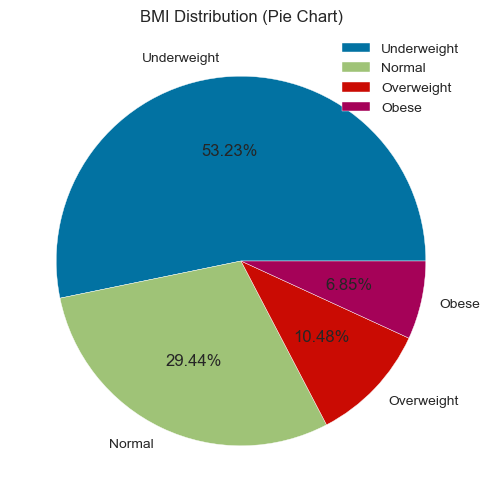

In [27]:
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data['BMI'].value_counts(), labels=data['BMI'].value_counts().index, autopct='%1.2f%%')
plt.title('BMI Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### Haemoglobin Levels

In [70]:
value_cnt_norm_cal(data, 'HB_LEVEL')

Count  Frequency (%)
HB_LEVEL                      
Normal      199      80.241935
Low          49      19.758065

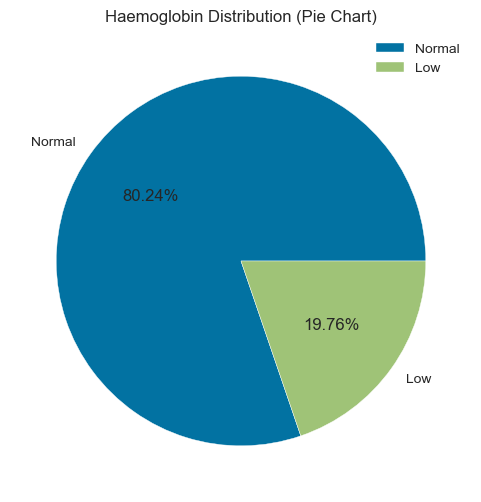

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data['HB_LEVEL'].value_counts(), labels=data['HB_LEVEL'].value_counts().index, autopct='%1.2f%%')
plt.title('Haemoglobin Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### Urea Levels

In [73]:
value_cnt_norm_cal(data, 'UREA_LEVEL')

Count  Frequency (%)
UREA_LEVEL                      
Abnormal      158      63.709677
Normal         90      36.290323

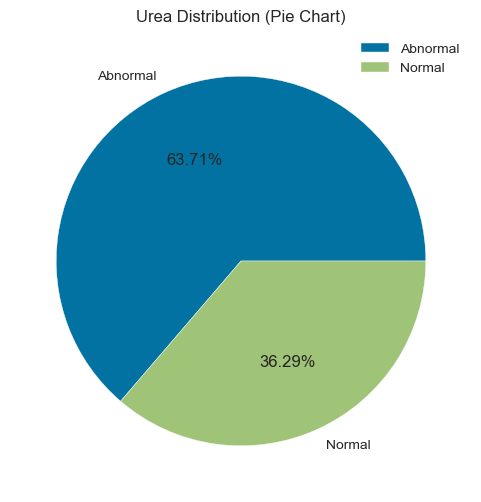

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data['UREA_LEVEL'].value_counts(), labels=data['UREA_LEVEL'].value_counts().index, autopct='%1.2f%%')
plt.title('Urea Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### Creatinine Levels

In [75]:
value_cnt_norm_cal(data, 'CREATININE_LEVEL')

Count  Frequency (%)
CREATININE_LEVEL                      
Abnormal            130      52.419355
Normal              118      47.580645

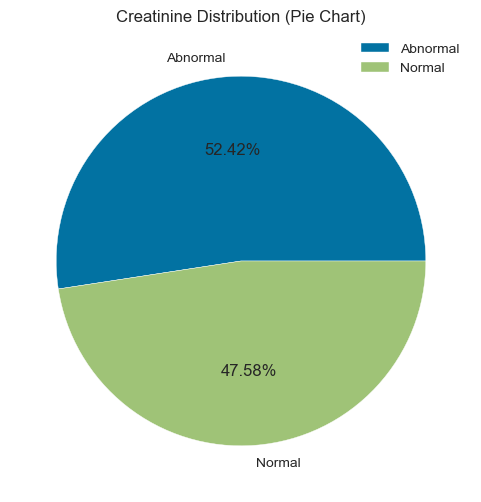

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
plt.pie(data['CREATININE_LEVEL'].value_counts(), labels=data['CREATININE_LEVEL'].value_counts().index, autopct='%1.2f%%')
plt.title('Creatinine Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### Distibution of numerical variables

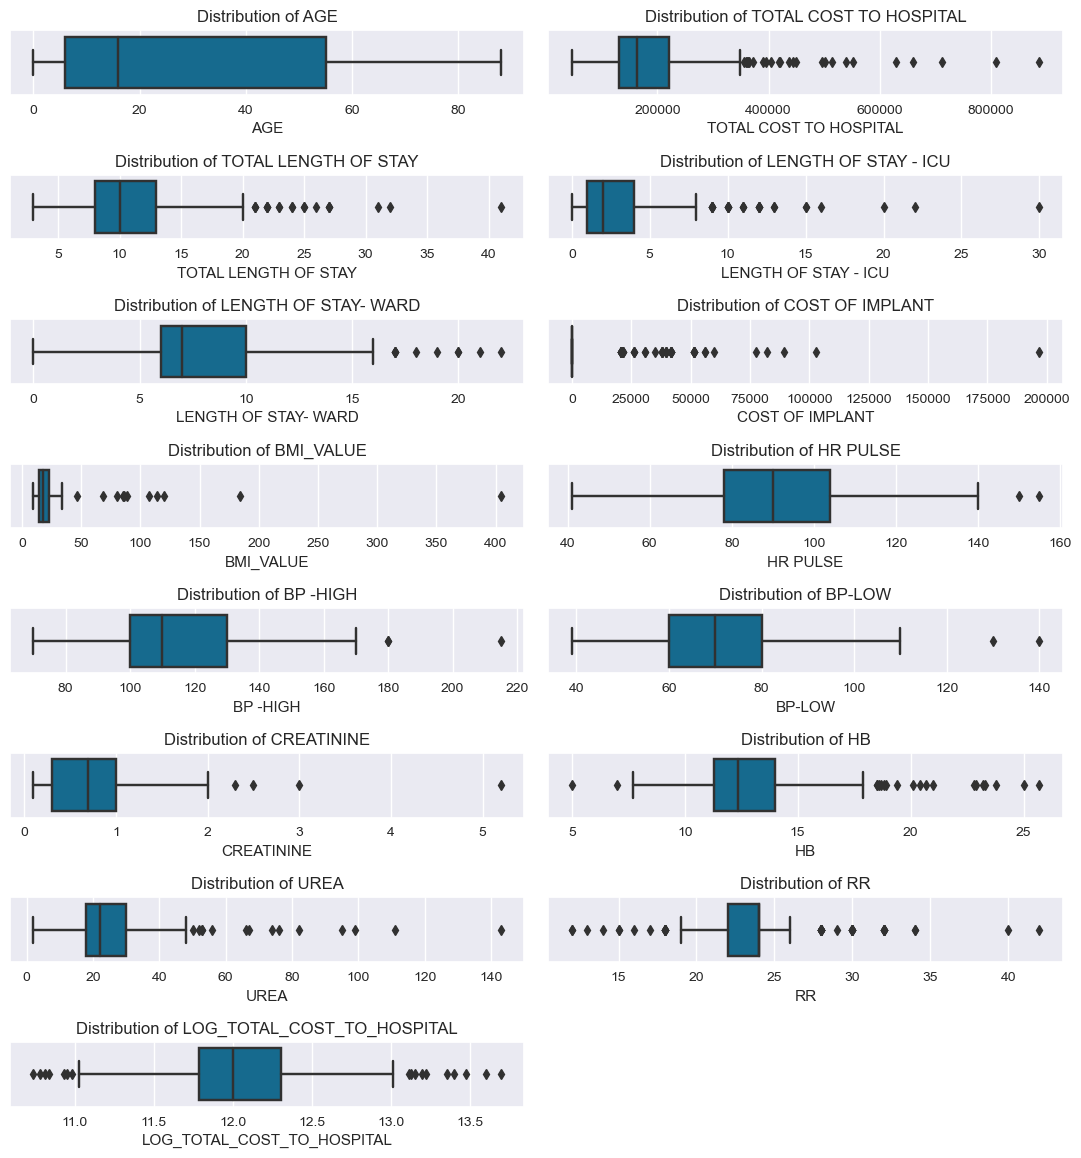

In [19]:
# numerical data

data_cat = data[['AGE','TOTAL COST TO HOSPITAL','TOTAL LENGTH OF STAY','LENGTH OF STAY - ICU','LENGTH OF STAY- WARD', 
                'COST OF IMPLANT','BMI_VALUE','HR PULSE','BP -HIGH','BP-LOW','CREATININE','HB','UREA','RR','LOG_TOTAL_COST_TO_HOSPITAL']]

# set figsize
plt.figure(figsize=(11,20))

# loop through column names and plot distributions
for i, col in enumerate(data_cat.columns):

  # set subplot
  plt.subplot(14,2,i+1)

  # seaborn boxplot
  sns.boxplot(data=data_cat, x=col)
  plt.title(f'Distribution of {col}')

# minimize risk of subplots overlapping
plt.tight_layout()

# show final plot after subplots finished generating
plt.show() 

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

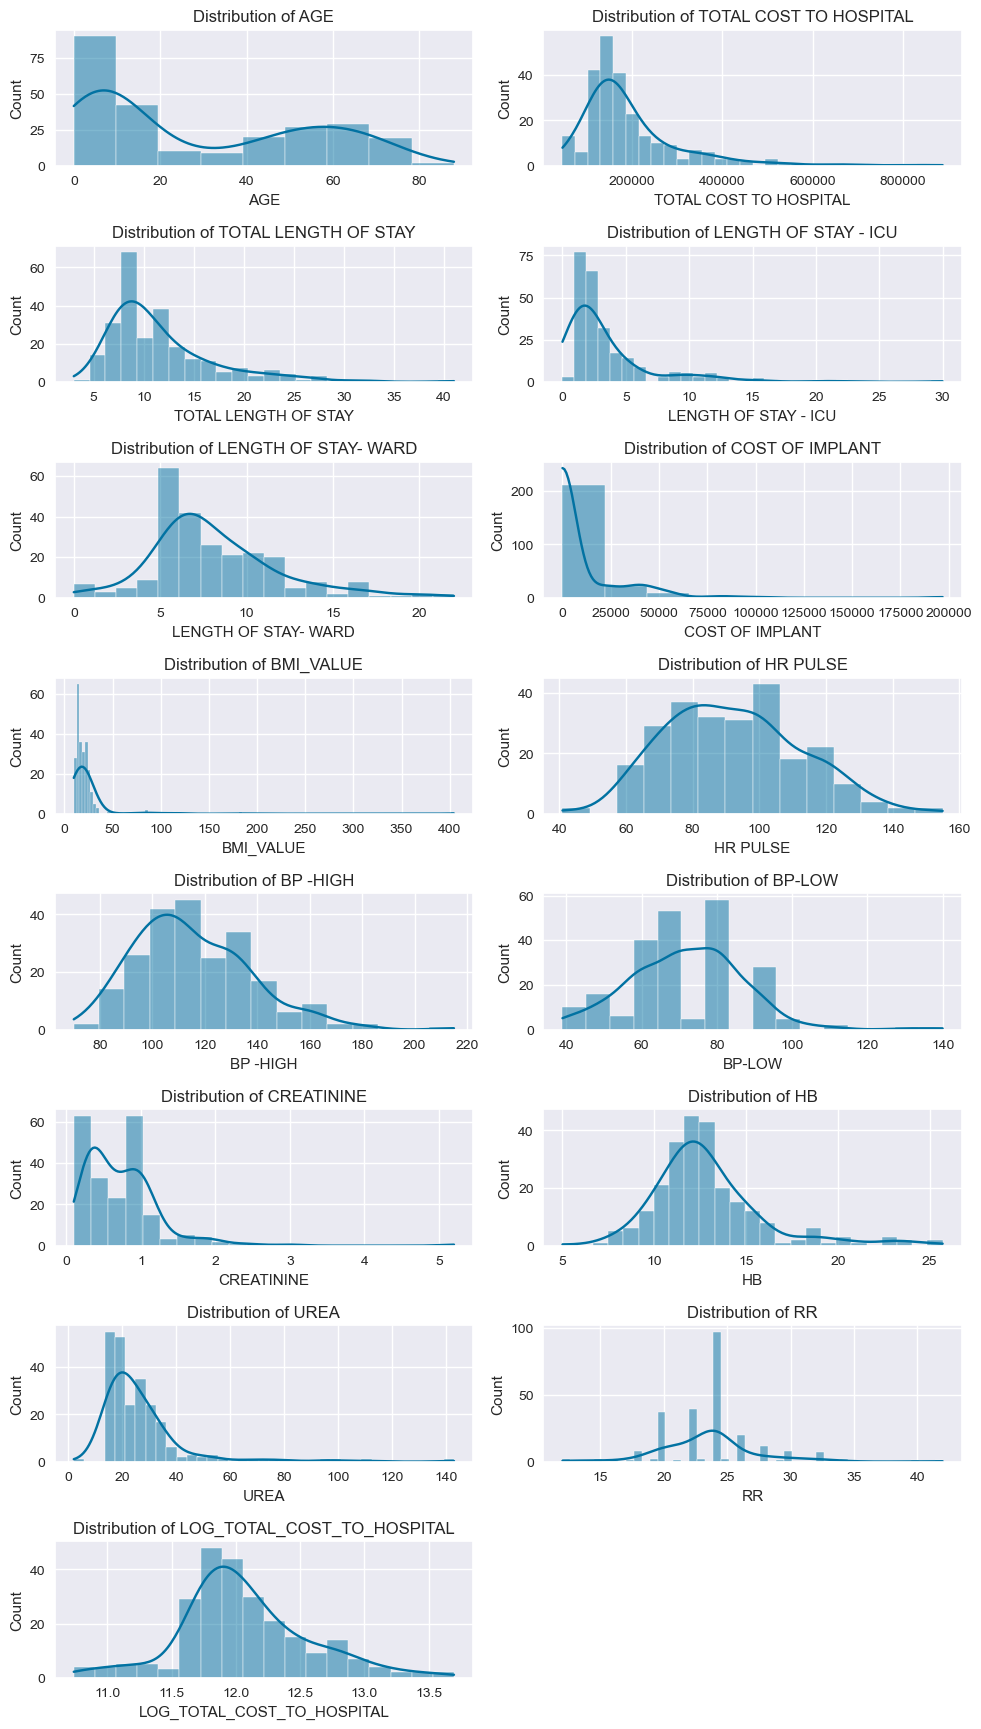

In [20]:
# Select the numerical columns
data_cat = data[['AGE','TOTAL COST TO HOSPITAL','TOTAL LENGTH OF STAY','LENGTH OF STAY - ICU','LENGTH OF STAY- WARD', 
                'COST OF IMPLANT','BMI_VALUE','HR PULSE','BP -HIGH','BP-LOW','CREATININE','HB','UREA','RR','LOG_TOTAL_COST_TO_HOSPITAL']]

# Set the figure size
plt.figure(figsize=(10,30))

# Loop through the column names and plot distributions
for i, col in enumerate(data_cat.columns):

    # Set subplot
    plt.subplot(14,2,i+1)

    # Seaborn histogram
    sns.histplot(data=data_cat, x=col, kde=True)
    plt.title(f'Distribution of {col}')

# Minimize risk of subplots overlapping
plt.tight_layout()

# Show final plot after subplots finished generating
plt.show()

## Bivariate Analysis

### Numerical vs numerical features (Correlation & scatter plots)

#### Scatter plots

C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mzing\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

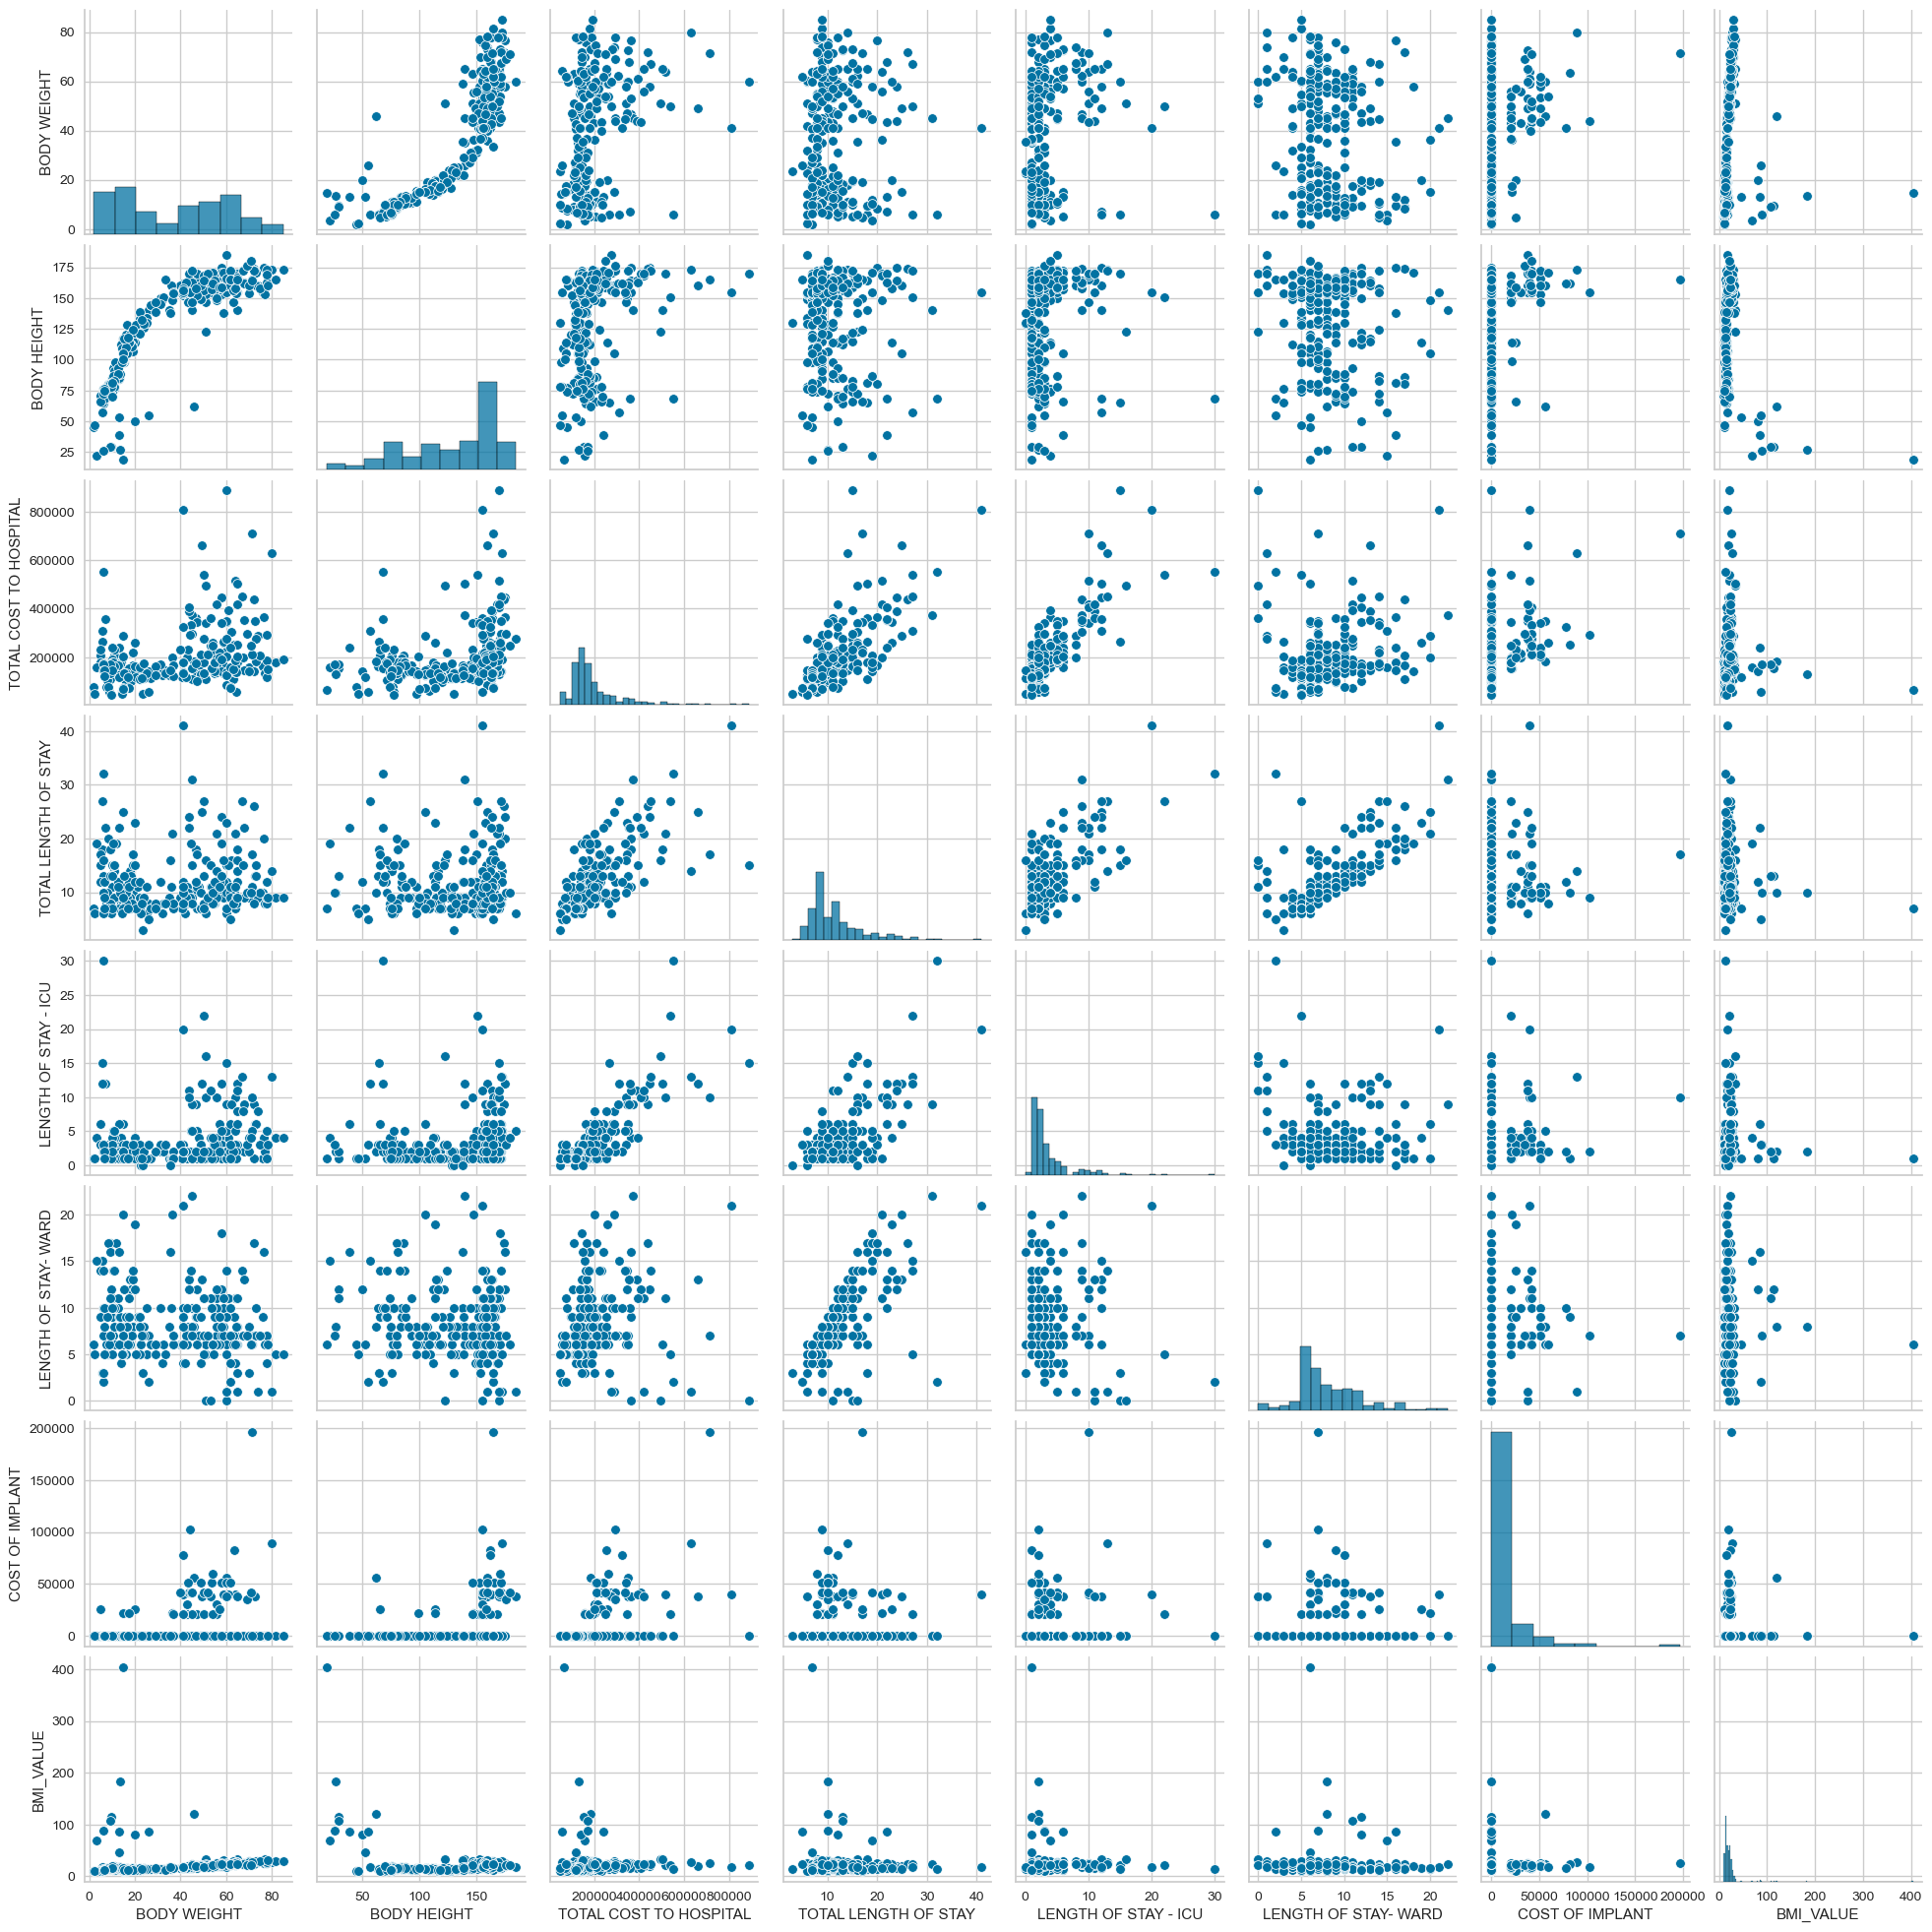

In [84]:
# Select only the numerical columns for the scatter plot matrix
numerical_df = data.select_dtypes(include=['float64', 'int64'])

# Drop the 'SL' column from the DataFrame
numerical_df = numerical_df.drop(['SL.', 'HR PULSE', 'BP -HIGH', 'BP-LOW', 'RR', 'HB', 'UREA', 'CREATININE'], axis=1)

# Create a pairplot to visualize the relationships between numerical variables
sns.pairplot(numerical_df)
plt.show()

##### Body Weight vs Total Cost To Hospital

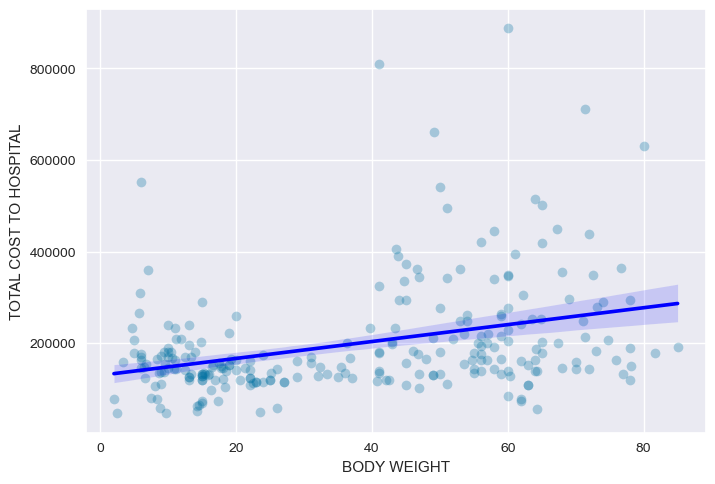

In [33]:
sns.regplot(x='BODY WEIGHT',y='TOTAL COST TO HOSPITAL',data=data,line_kws={'color':'blue'},scatter_kws={'alpha':0.3})
plt.show()

##### Total length of stay vs Total Cost To Hospital

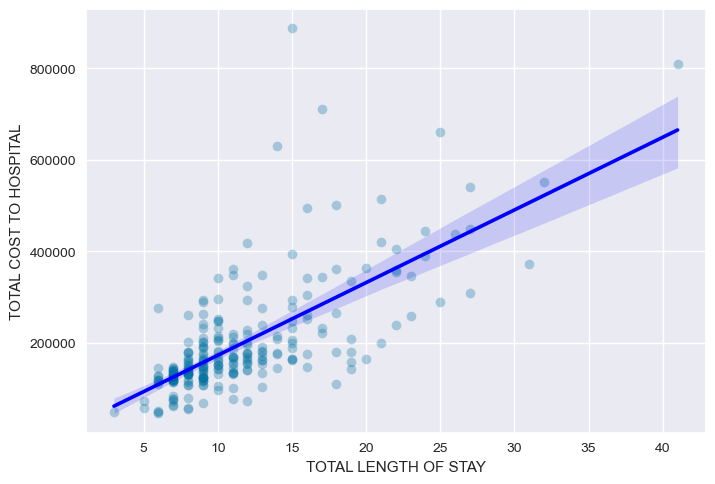

In [34]:
sns.regplot(x='TOTAL LENGTH OF STAY',y='TOTAL COST TO HOSPITAL',data=data,line_kws={'color':'blue'},scatter_kws={'alpha':0.3})
plt.show()

#### Correlation analysis

Text(0.5, 1.0, "Pearson's Correlation heatmap")

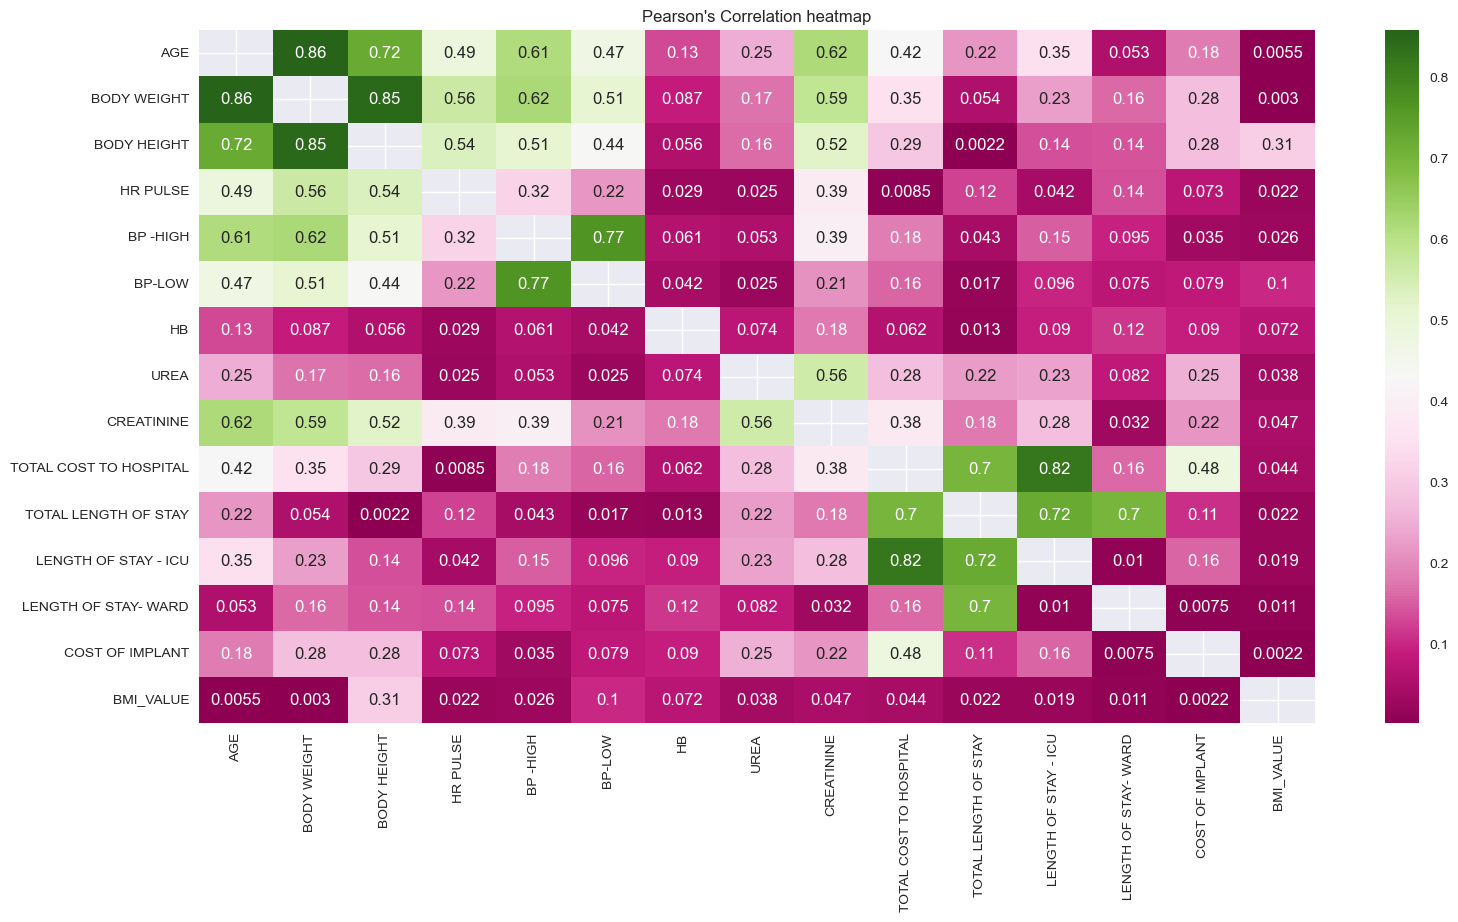

In [38]:
# Select only the numerical columns for the correlation matrix
numerical_df = data.select_dtypes(include=['float64', 'int64'])

# Drop the 'SL' column from the DataFrame
numerical_df = numerical_df.drop(['SL.','RR'], axis=1)

# calculate correlations in dataset
corr=abs(numerical_df.corr())

# plot correlations using heatmap
plt.figure(figsize=(18,9))
sns.heatmap(corr[corr<1], cmap='PiYG', annot=True)
plt.title("Pearson's Correlation heatmap")

#### Total Cost To Hospital vs the rest of categorical features (ANOVA)

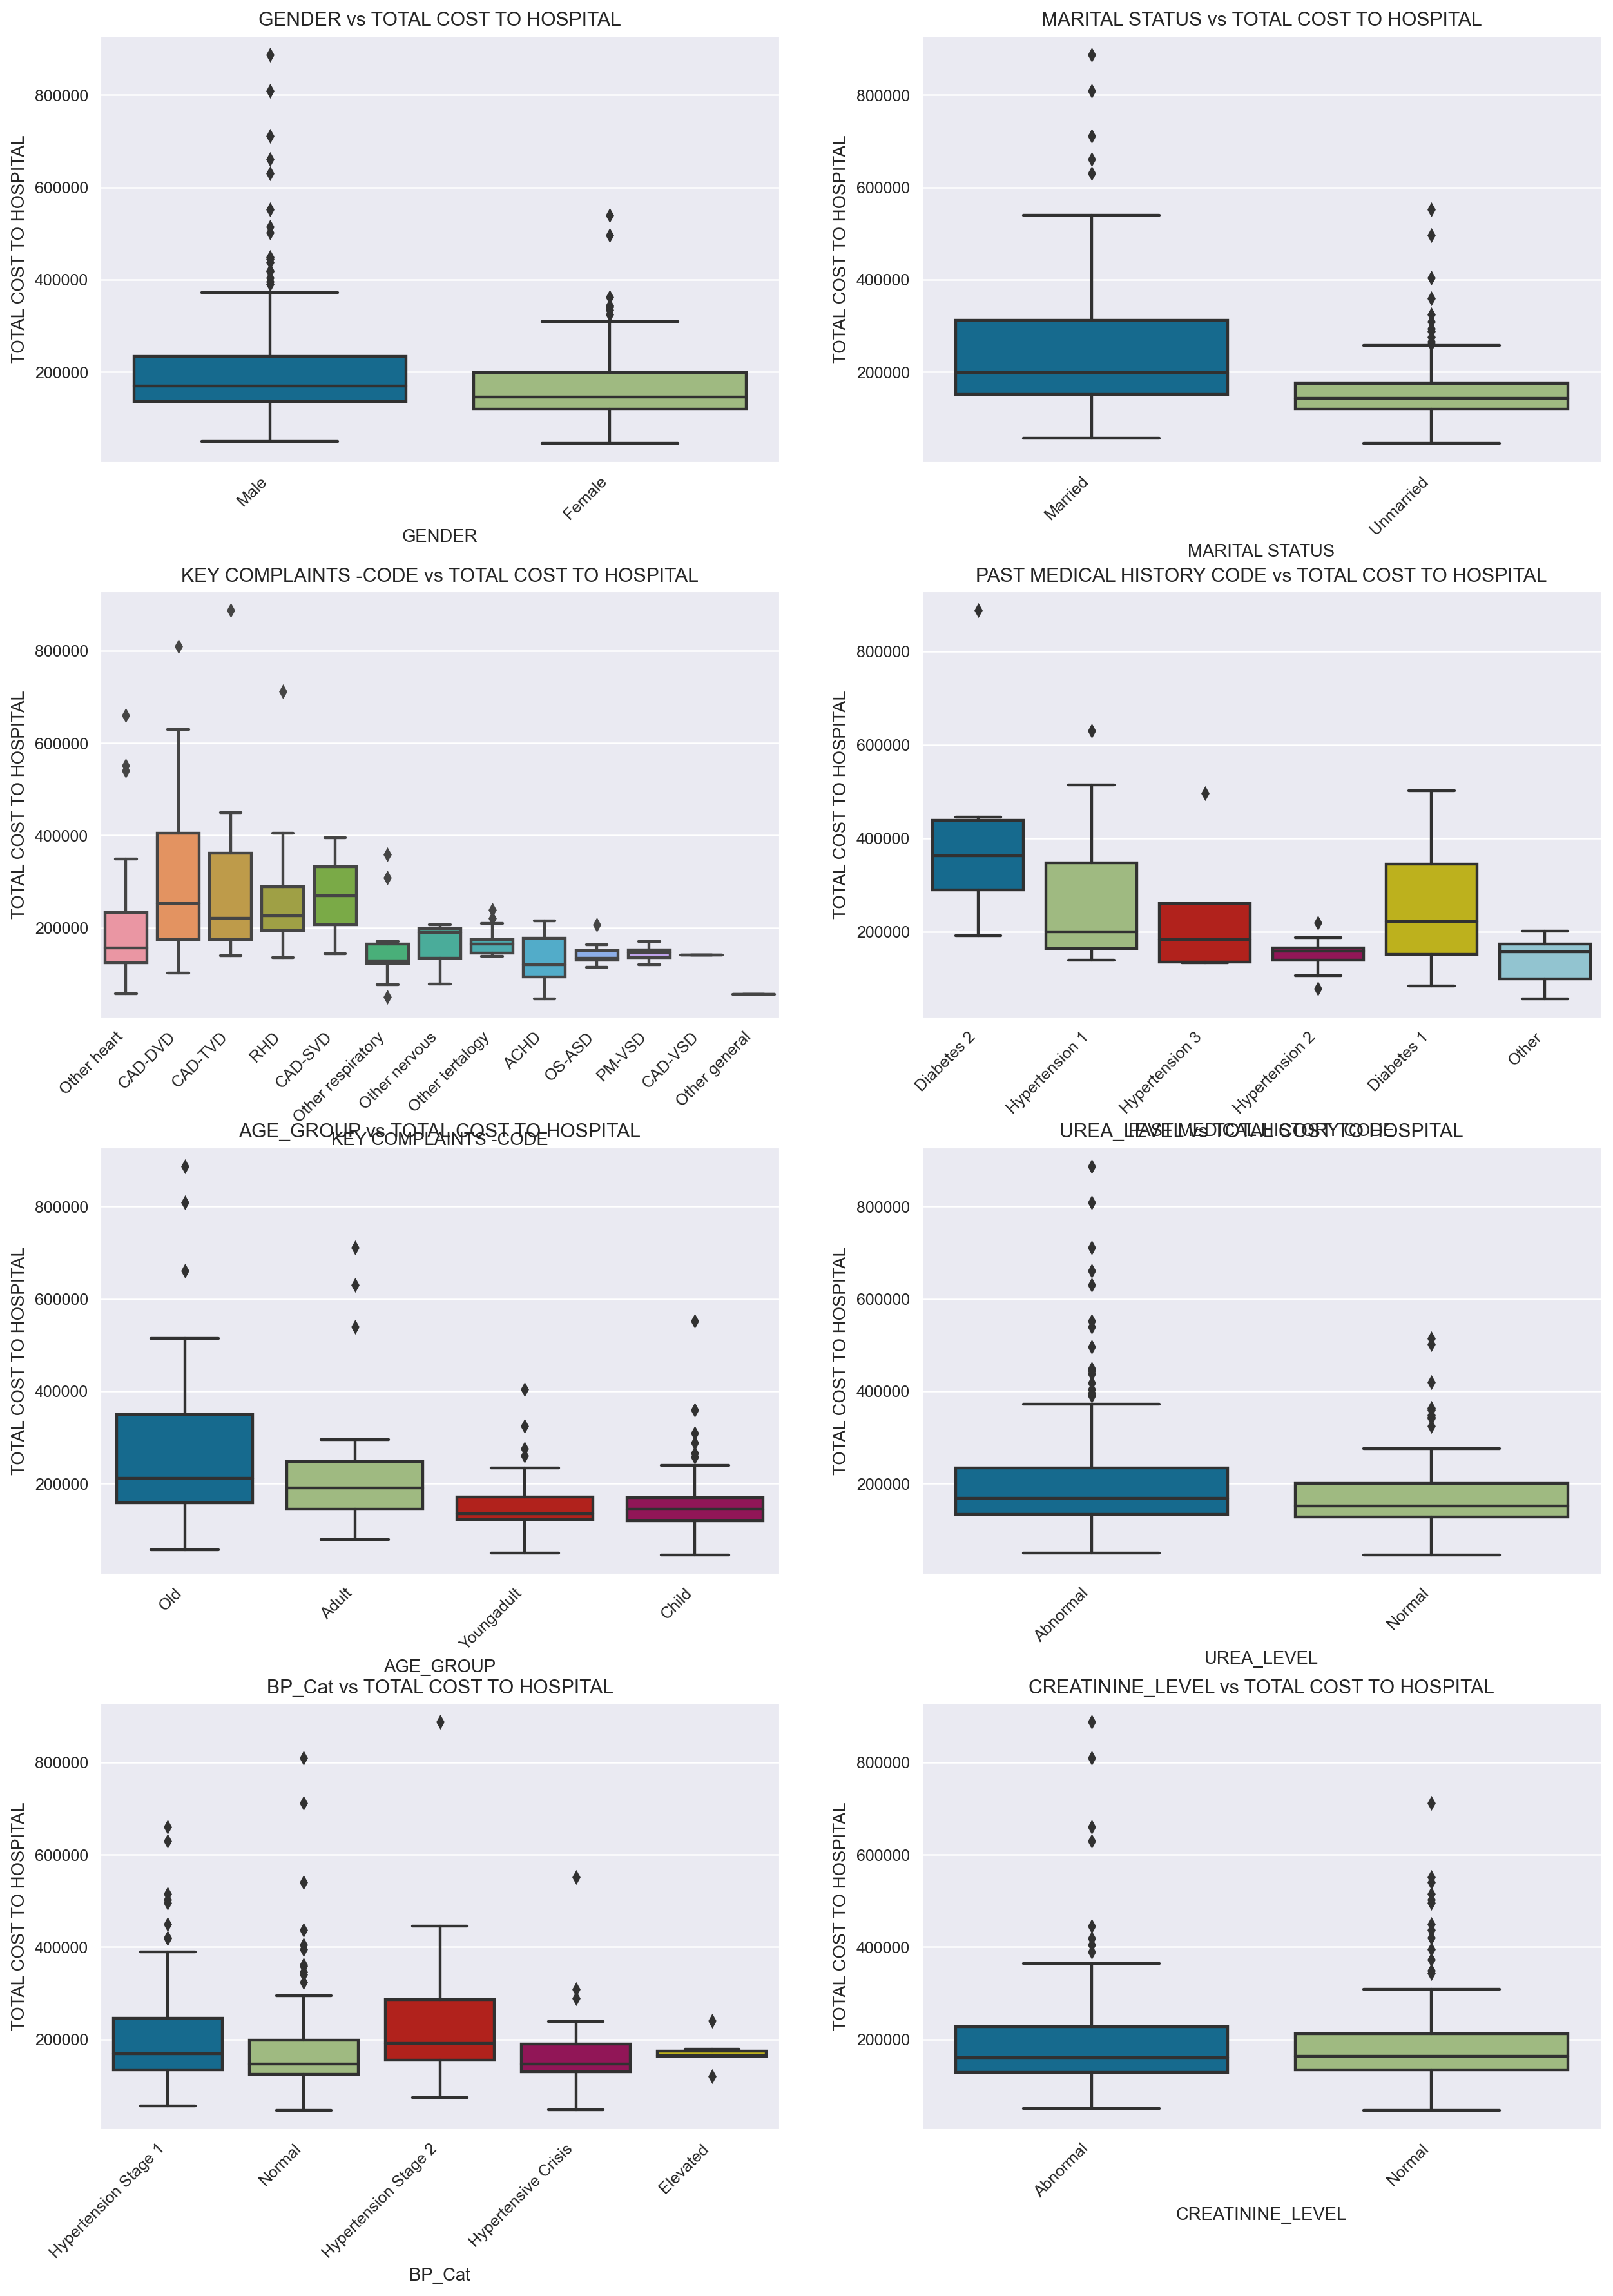

In [39]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['GENDER','MARITAL STATUS','KEY COMPLAINTS -CODE','PAST MEDICAL HISTORY CODE','AGE_GROUP','UREA_LEVEL','BP_Cat','CREATININE_LEVEL','BMI','IMPLANT USED (Y/N)', 'HB_LEVEL']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=data[cat_features[cat_ft_count]],y=data['TOTAL COST TO HOSPITAL'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs TOTAL COST TO HOSPITAL")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('TOTAL COST TO HOSPITAL')
            cat_ft_count += 1
    break

#### T-Tests

In [34]:
t_stat, p_val = stats.ttest_ind(data[data['GENDER'] == 'Male']['TOTAL COST TO HOSPITAL'],
                                data[data['GENDER'] == 'Female']['TOTAL COST TO HOSPITAL'])
print(f"T-Test: t_stat = {t_stat}, p_val = {p_val}")

T-Test: t_stat = 2.426358517880483, p_val = 0.015970815512801745


#### ANOVA

In [35]:
f_stat, p_val = stats.f_oneway(data[data['AGE_GROUP'] == 'Child']['TOTAL COST TO HOSPITAL'],
                               data[data['AGE_GROUP'] == 'Youngadult']['TOTAL COST TO HOSPITAL'],
                               data[data['AGE_GROUP'] == 'Adult']['TOTAL COST TO HOSPITAL'],
                               data[data['AGE_GROUP'] == 'Old']['TOTAL COST TO HOSPITAL'])
print(f"ANOVA: f_stat = {f_stat}, p_val = {p_val}")

ANOVA: f_stat = 16.946836418025534, p_val = 4.959554830929893e-10


#### Chi-Square Test

In [36]:
contingency_table = pd.crosstab(data['GENDER'], data['AGE_GROUP'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square: chi2 = {chi2}, p_val = {p_val}")

Chi-Square: chi2 = 13.21447116587218, p_val = 0.0041950252310384755


# Prepare the data

## Data Cleaning

### Outlier remover

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers=None):
        self.feat_with_outliers = feat_with_outliers or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_features = set(self.feat_with_outliers) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        # Calculate 25% and 75% quantiles
        Q1 = X[self.feat_with_outliers].quantile(0.25)
        Q3 = X[self.feat_with_outliers].quantile(0.75)
        IQR = Q3 - Q1

        # Keep data within 1.5 IQR
        X = X[~((X[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (X[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
        return X

### Missing values imputer

In [17]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_imputed_ft=None, median_imputed_ft=None):

        self.mode_imputed_ft = mode_imputed_ft or []
        self.median_imputed_ft = median_imputed_ft or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        missing_features = set(self.mode_imputed_ft + self.median_imputed_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        # Impute missing values with mode
        for ft in self.mode_imputed_ft:
            the_mode = X[ft].mode()[0]
            X[ft] = X[ft].fillna(the_mode)

        # Impute missing values with median
        for ft in self.median_imputed_ft:
            the_median = X[ft].median()
            X[ft] = X[ft].fillna(the_median)

        return X

### Feature drop

In [18]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_drop=None):

        self.feature_to_drop = feature_to_drop or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        missing_features = set(self.feature_to_drop) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")
        return X.drop(columns=self.feature_to_drop)

### Min-Max scaling

In [19]:
class MinMaxWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, min_max_scaler_ft=None):

        self.min_max_scaler_ft = min_max_scaler_ft or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        missing_features = set(self.min_max_scaler_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        min_max_enc = MinMaxScaler()
        X[self.min_max_scaler_ft] = min_max_enc.fit_transform(X[self.min_max_scaler_ft])
        return X

### One hot encoding

In [20]:
class OneHotWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc_ft=None):
        self.one_hot_enc_ft = one_hot_enc_ft or []
        self.one_hot_enc = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        self.one_hot_enc.fit(X[self.one_hot_enc_ft])
        self.feat_names_one_hot_enc = self.one_hot_enc.get_feature_names_out(self.one_hot_enc_ft)
        return self

    def transform(self, X):
        missing_features = set(self.one_hot_enc_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        one_hot_enc_df = pd.DataFrame(self.one_hot_enc.transform(X[self.one_hot_enc_ft]).toarray(), columns=self.feat_names_one_hot_enc, index=X.index)
        rest_of_features = [ft for ft in X.columns if ft not in self.one_hot_enc_ft]
        df_concat = pd.concat([one_hot_enc_df, X[rest_of_features]], axis=1)
        return df_concat

### Ordinal encoding

In [21]:
class OrdinalEncoderWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_enc_ft=None):
        self.ordinal_enc_ft = ordinal_enc_ft or []
        self.ordinal_enc = OrdinalEncoder()

    def fit(self, X, y=None):
        self.ordinal_enc.fit(X[self.ordinal_enc_ft])
        return self

    def transform(self, X):
        missing_features = set(self.ordinal_enc_ft) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        ordinal_enc_df = pd.DataFrame(self.ordinal_enc.transform(X[self.ordinal_enc_ft]), columns=self.ordinal_enc_ft, index=X.index)
        rest_of_features = [ft for ft in X.columns if ft not in self.ordinal_enc_ft]
        df_concat = pd.concat([ordinal_enc_df, X[rest_of_features]], axis=1)
        return df_concat

### Skewness Handler

In [22]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self, col_with_skewness=None):

        self.col_with_skewness = col_with_skewness or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        missing_features = set(self.col_with_skewness) - set(X.columns)
        if missing_features:
            raise ValueError(f"Features not found in DataFrame: {missing_features}")

        X[self.col_with_skewness] = np.cbrt(X[self.col_with_skewness])
        return X

### Drop uncommon complaints

In [23]:
class DropUncommonComplaint(BaseEstimator, TransformerMixin):
    def __init__(self, complaint_list=None):
 
        self.complaint_list = complaint_list or []

    def fit(self, X, y=None):

        return self

    def transform(self, X):

        if 'KEY COMPLAINTS -CODE' in X.columns:
            X = X[~X['KEY COMPLAINTS -CODE'].isin(self.complaint_list)]
            return X
        else:
            print("KEY COMPLAINTS -CODE feature is not in the dataframe")
            return X

## Data Preprocessing

In [24]:
# Create the pipeline
pipeline = Pipeline([
    ('missing values imputer', MissingValueImputer(mode_imputed_ft=['KEY COMPLAINTS -CODE'], median_imputed_ft=['HB','UREA','CREATININE','BP -HIGH','BP-LOW'])),
    ('drop features', DropFeatures(feature_to_drop=['BP_Cat','IMPLANT USED (Y/N)','AGE_GROUP','LOG_TOTAL_COST_TO_HOSPITAL','SL.','BODY WEIGHT','BODY HEIGHT',
                                                   'PAST MEDICAL HISTORY CODE','BMI','STATE AT THE TIME OF ARRIVAL',
                                                    'CREATININE_LEVEL','HB_LEVEL','UREA_LEVEL'])),
    ('skewness handler', SkewnessHandler(col_with_skewness=['RR','CREATININE','BP -HIGH','BP-LOW','TOTAL LENGTH OF STAY','LENGTH OF STAY - ICU','BMI_VALUE','UREA','COST OF IMPLANT'])),
    ('min max scaler', MinMaxWithFeatNames(min_max_scaler_ft=['RR','CREATININE','BP -HIGH','BP-LOW','AGE','HR PULSE','HB','LENGTH OF STAY- WARD','UREA','BMI_VALUE','TOTAL LENGTH OF STAY','COST OF IMPLANT','LENGTH OF STAY - ICU'])),
    ('drop uncommon complaint', DropUncommonComplaint(complaint_list=['PM-VSD','Other nervous','CAD-SVD','CAD-VSD','Other general'])),
    ('one hot encoder', OneHotWithFeatNames(one_hot_enc_ft=['GENDER','MODE OF ARRIVAL','MARITAL STATUS','TYPE OF ADMSN','KEY COMPLAINTS -CODE']))
])

In [25]:
# Apply the pipeline to the DataFrame
pd.options.mode.chained_assignment = None
train_copy_prep = pipeline.fit_transform(train_copy)

In [26]:
# Apply the pipeline to the DataFrame
pd.options.mode.chained_assignment = None
test_copy_prep = pipeline.fit_transform(test_copy)

In [27]:
train_copy_prep.shape, test_copy_prep.shape

((186, 31), (49, 31))

In [28]:
X_cost_amt_train_prep, y_cost_amt_train_prep = train_copy_prep.loc[:, train_copy_prep.columns != 'TOTAL COST TO HOSPITAL'], train_copy_prep['TOTAL COST TO HOSPITAL']

In [29]:
X_cost_amt_train_prep.head(3)

GENDER_Female  GENDER_Male  MODE OF ARRIVAL_Ambulance  \
0            1.0          0.0                        0.0   
1            0.0          1.0                        0.0   
2            0.0          1.0                        0.0   

   MODE OF ARRIVAL_Transferred  MODE OF ARRIVAL_Walked in  \
0                          0.0                        1.0   
1                          0.0                        1.0   
2                          0.0                        1.0   

   MARITAL STATUS_Married  MARITAL STATUS_Unmarried  TYPE OF ADMSN_Elective  \
0                     0.0                       1.0                     1.0   
1                     0.0                       1.0                     1.0   
2                     0.0                       1.0                     1.0   

   TYPE OF ADMSN_Emergency  KEY COMPLAINTS -CODE_ACHD  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   

   KEY COMPLAINTS -CODE_CAD-DVD  KEY COMPLAINTS -CODE_CAD-TVD  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   

   KEY COMPLAINTS -CODE_OS-ASD  KEY COMPLAINTS -CODE_Other heart  \
0                          0.0                               1.0   
1                          0.0                               1.0   
2                          0.0                               0.0   

   KEY COMPLAINTS -CODE_Other respiratory  \
0                                     0.0   
1                                     0.0   
2                                     1.0   

   KEY COMPLAINTS -CODE_Other tertalogy  KEY COMPLAINTS -CODE_RHD       AGE  \
0                                   0.0                       0.0  0.060976   
1                                   0.0                       0.0  0.036585   
2                                   0.0                       0.0  0.060976   

   HR PULSE  BP -HIGH    BP-LOW        RR        HB      UREA  CREATININE  \
0  0.393939  0.278320  0.405308  0.358158  0.671498  0.317408    0.214967   
1  0.494949  0.358468  0.290713  0.432000  0.275362  0.366427    0.000000   
2  0.828283  0.192635  0.162562  0.501493  0.859903  0.354835    0.161847   

   TOTAL LENGTH OF STAY  LENGTH OF STAY - ICU  LENGTH OF STAY- WARD  \
0              0.278046              0.321830              0.318182   
1              0.317968              0.405480              0.318182   
2              0.389702              0.464159              0.363636   

   COST OF IMPLANT  BMI_VALUE  
0              0.0   0.066267  
1              0.0   0.063116  
2              0.0   0.073659

# Short-list promising models

## Model training

In [30]:
Regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Elastic Net Regression': ElasticNet(random_state=42),
    'KNN Regression': KNeighborsRegressor(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regression': AdaBoostRegressor(random_state=42),
    'Bagging Regression': BaggingRegressor(random_state=42),
    'Extra Trees Regression': ExtraTreesRegressor(random_state=42),
    'Kernel Ridge Regression': KernelRidge(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Stochastic Gradient Descent Regression': SGDRegressor(random_state=42),
    'SVM Regression': SVR(),
    'Gaussian Process Regression': GaussianProcessRegressor(random_state=42),
    'XGBoost Regression': XGBRegressor(random_state=42)
}

In [31]:
def scores_cal_fuc(model, model_name, final_model=False):
    # Adding RMSE to the score list
    score_list = ['mae']
    scores = []
    scores_mean_for_each_type = []
    scores_mean = 0
    scores_std = 0
    # path to save the model folder
    model_dir_path = Path('saved_trained_models/{0}/'.format(model_name))
    files_start_with_score_path = []
    # for loop to check if there is any file start with 'score' in the model folder
    for i in os.listdir(model_dir_path):
        if os.path.isfile(os.path.join(model_dir_path, i)) and 'score' in i:
            files_start_with_score_path.append(os.path.join(model_dir_path, i))
    # file that start with 'score' found, load the scores list, mean and std using pickle
    if files_start_with_score_path:
        for score_type in score_list:
            # load the scores list
            with open('saved_trained_models/{0}/score_{1}_list.pickle'.format(model_name, score_type), 'rb') as handle:
                scores = pickle.load(handle)
            # load the mean score
            with open('saved_trained_models/{0}/score_{1}_mean.pickle'.format(model_name, score_type), 'rb') as handle:
                scores_mean = pickle.load(handle)
                scores_mean_for_each_type.append(scores_mean)
            # load the std score
            with open('saved_trained_models/{0}/score_{1}_std.pickle'.format(model_name, score_type), 'rb') as handle:
                scores_std = pickle.load(handle)
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
        return scores_mean_for_each_type
    # no file start with score in the model folder
    else:
        for score_type in score_list:
            if score_type == 'mae':
                # calculate RMSE using kfold cross validation
                rmse_scorer = make_scorer(mean_absolute_error)
                scores = cross_val_score(model, X_cost_amt_train_prep, y_cost_amt_train_prep, scoring=rmse_scorer, cv=3)
            else:
                # calculate the scores for each score type using kfold cross validation
                scores = cross_val_score(model, X_cost_amt_train_prep, y_cost_amt_train_prep, scoring=score_type, cv=3)
            scores_mean = scores.mean()
            scores_mean_for_each_type.append(scores_mean)
            scores_std = scores.std()
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
            # save the scores using pickle
            with open('saved_trained_models/{0}/score_{1}_list.pickle'.format(model_name, score_type), 'wb') as handle:
                pickle.dump(scores, handle)
            # save the mean scores using pickle
            with open('saved_trained_models/{0}/score_{1}_mean.pickle'.format(model_name, score_type), 'wb') as handle:
                pickle.dump(scores_mean, handle)
            # save the standard deviation scores using pickle
            with open('saved_trained_models/{0}/score_{1}_std.pickle'.format(model_name, score_type), 'wb') as handle:
                pickle.dump(scores_std, handle)
        return scores_mean_for_each_type

In [32]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_trained_models/{}/'.format(model_name)):
        os.makedirs('saved_trained_models/{}/'.format(model_name))

In [33]:
# loop over all the models
for model_name, model in Regressors.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model(model_name)
    # fit and score the model
    scores_cal_fuc(model, model_name)





----------------------  Linear Regression  ----------------------



                        mae score

Scores: [36681.94129032 33691.60516129 36235.36112903]

Mean of the scores: 35536.30252688172

Standard deviation of the scores: 1317.0775067244933






----------------------  Ridge Regression  ----------------------



                        mae score

Scores: [41067.7012103  30372.32878973 39219.89353317]

Mean of the scores: 36886.641177732854

Standard deviation of the scores: 4667.675918432693






----------------------  Lasso Regression  ----------------------




C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.988e+09, tolerance: 1.648e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e+10, tolerance: 1.925e+08
  model = cd_fast.enet_coordinate_descent(



                        mae score

Scores: [36626.32131701 32613.39232359 34834.92390821]

Mean of the scores: 34691.54584960224

Standard deviation of the scores: 1641.4054399263905






----------------------  Elastic Net Regression  ----------------------



                        mae score

Scores: [72742.69962346 59811.10467051 65502.38876045]

Mean of the scores: 66018.73101814202

Standard deviation of the scores: 5291.911689997287






----------------------  KNN Regression  ----------------------



                        mae score

Scores: [66140.19783871 58148.6606129  63693.03141935]

Mean of the scores: 62660.62995698925

Standard deviation of the scores: 3343.207680505204






----------------------  Decision Tree Regression  ----------------------



                        mae score

Scores: [45063.08290323 53986.71290323 45152.39532258]

Mean of the scores: 48067.39704301075

Standard deviation of the scores: 4185.747194691997






----------------------  Random

C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\mzing\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



                        mae score

Scores: [40815.66945078 30887.45291377 38138.9102428 ]

Mean of the scores: 36614.01086911391

Standard deviation of the scores: 4194.151441897348






----------------------  SVM Regression  ----------------------



                        mae score

Scores: [79855.94558579 70541.61265193 76873.23156922]

Mean of the scores: 75756.92993564741

Standard deviation of the scores: 3883.6234372522445






----------------------  Gaussian Process Regression  ----------------------



                        mae score

Scores: [58007.72344127 50163.45957751 57096.56639719]

Mean of the scores: 55089.24980532355

Standard deviation of the scores: 3502.8663325968664






----------------------  XGBoost Regression  ----------------------



                        mae score

Scores: [46051.92553931 36704.21008065 40633.57277722]

Mean of the scores: 41129.90279905914

Standard deviation of the scores: 3832.2929334796772




# Selected models to tune

- Extra Trees Regression
- Gradient Boosting Regression
- Lasso Regression
- Random Forest Regression

# Fine tuning the model

In [34]:
def train_model(best_model, model_name, X_cost_amt_train_prep, y_cost_amt_train_prep):
    trained_model_path = Path('saved_final_models/{0}/trained_{0}'.format(model_name))
    try:
        trained_model_path.resolve(strict=True)
    except FileNotFoundError:
        #train the model with the best parameters
        best_model_trn = best_model.fit(X_cost_amt_train_prep, y_cost_amt_train_prep)
        joblib.dump(best_model_trn, 'saved_final_models/{0}/trained_{0}'.format(model_name))
    else:
        best_model_trn = joblib.load('saved_final_models/{0}/trained_{0}'.format(model_name))
    return best_model_trn

In [35]:
# def fine_tune_model(model_name,model, parameters,X_cost_amt_train_prep, y_cost_amt_train_prep):
#     folder_check_model(model_name)
#     rand_search_path = Path('saved_final_models/{0}/rand_search_{0}'.format(model_name))
#     try:
#         rand_search_path.resolve(strict=True)
#     except FileNotFoundError:
#         rand_search = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
#         rand_search.fit(X_cost_amt_train_prep, y_cost_amt_train_prep)
#         joblib.dump(rand_search, 'saved_final_models/{0}/rand_search_{0}'.format(model_name))
#         best_model = rand_search.best_estimator_
#         rand_res = rand_search.cv_results_
#         print('*'*50)
#         for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
#             print(np.sqrt(-mean_score), params)
#     else:
#         rand_search = joblib.load('saved_final_models/{0}/rand_search_{0}'.format(model_name))
#         best_model = rand_search.best_estimator_
#         rand_res = rand_search.cv_results_
#         for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
#             print(np.sqrt(-mean_score), params)
#     return best_model

In [36]:
def fine_tune_model(model_name, model, parameters, X_cost_amt_train_prep, y_cost_amt_train_prep):
    folder_check_model(model_name)
    rand_search_path = Path('saved_final_models/{0}/rand_search_{0}'.format(model_name))
    try:
        rand_search_path.resolve(strict=True)
    except FileNotFoundError:
        rand_search = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', cv=3, verbose=5, return_train_score=True, error_score='raise')
        rand_search.fit(X_cost_amt_train_prep, y_cost_amt_train_prep)
        joblib.dump(rand_search, 'saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        print('*'*50)
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(-mean_score, params)
    else:
        rand_search = joblib.load('saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(-mean_score, params)
    return best_model

In [37]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_final_models/{}/'.format(model_name)):
        os.makedirs('saved_final_models/{}/'.format(model_name))

## Extra Trees Regression

In [38]:
n_samples = X_cost_amt_train_prep.shape[0]

parameters = [
    {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': [10, 20, 30, 40, 50, 60, None],
    'min_samples_split': [2, 0.5, n_samples//2, ],
    'min_samples_leaf': [1, 0.5, n_samples//2, ]
    }
] 

In [39]:
extra_trees_dict = {'Extra Trees Regression': ExtraTreesRegressor(random_state=42)}

In [40]:
model_name, model = list(extra_trees_dict.keys())[0], list(extra_trees_dict.values())[0]

In [41]:
best_model = fine_tune_model(model_name, model, parameters,X_cost_amt_train_prep, y_cost_amt_train_prep)

Fitting 3 folds for each of 315 candidates, totalling 945 fits
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=-2424.350, test=-36588.618) total time=   2.8s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=-2752.192, test=-27470.087) total time=   8.4s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=-2637.663, test=-33245.207) total time=   3.8s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=(train=-2517.174, test=-35835.405) total time=   5.0s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=(train=-2747.777, test=-26792.106) total time=   9.1s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=(train=-2615.397, test=-33161.687) total time=   4.8s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samp

In [43]:
best_extra_trees_trn = train_model(best_model, model_name,X_cost_amt_train_prep, y_cost_amt_train_prep)

## Gradient Boosting Regression

In [44]:
parameters = [{
    'n_estimators':[200, 400, 600, 800, 1000],
    'max_depth':[1,3,5,7,9],
    'learning_rate':[0.01,0.1,1],
}]

In [45]:
grad_boost_dict = {'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42)}

In [46]:
model_name, model = list(grad_boost_dict.keys())[0], list(grad_boost_dict.values())[0]

In [47]:
best_model = fine_tune_model(model_name, model, parameters,X_cost_amt_train_prep, y_cost_amt_train_prep)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=(train=-42238.545, test=-44980.783) total time=   1.1s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=(train=-42115.732, test=-35972.712) total time=   1.2s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=(train=-39117.893, test=-45394.653) total time=   0.6s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=400;, score=(train=-28832.855, test=-32927.828) total time=   1.9s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimators=400;, score=(train=-31027.882, test=-29091.660) total time=   4.4s
[CV 3/3] END learning_rate=0.01, max_depth=1, n_estimators=400;, score=(train=-27081.429, test=-35106.934) total time=   2.5s
[CV 1/3] END learning_rate=0.01, max_depth=1, n_estimators=600;, score=(train=-23867.527, test=-30361.223) total time=   3.3s
[CV 2/3] END learning_rate=0.01, max_depth=1, n_estimato

In [48]:
best_grad_boost_trn = train_model(best_model, model_name,X_cost_amt_train_prep, y_cost_amt_train_prep)

## Random Forest Regression

In [49]:
parameters = [
    {'max_depth': [10, 20, 30, 40, 50, 60, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000]}
]

In [50]:
rand_forest_dict = {'Random Forest Regression': RandomForestRegressor(random_state=42)}

In [51]:
model_name, model = list(rand_forest_dict.keys())[0], list(rand_forest_dict.values())[0]

In [52]:
best_model = fine_tune_model(model_name, model, parameters,X_cost_amt_train_prep, y_cost_amt_train_prep)

Fitting 3 folds for each of 315 candidates, totalling 945 fits
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=-12568.001, test=-35758.966) total time=   4.6s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=-14000.872, test=-34129.552) total time=   3.1s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=-12916.078, test=-34688.478) total time=   2.8s
[CV 1/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=(train=-12217.804, test=-35811.011) total time=   5.4s
[CV 2/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=(train=-13814.159, test=-33503.628) total time=   5.5s
[CV 3/3] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=(train=-12762.609, test=-34790.242) total time=   5.5s
[CV 1/3] END max_depth=10, min_samples_leaf=1, mi

In [53]:
best_rand_for_trn = train_model(best_model, model_name,X_cost_amt_train_prep, y_cost_amt_train_prep)

# Test the models on the test set

In [54]:
test_copy.head(3)

SL.  AGE GENDER MARITAL STATUS KEY COMPLAINTS -CODE  BODY WEIGHT  \
0   34    7   Male      Unmarried    Other respiratory          7.0   
1    7   73   Male        Married              CAD-TVD         60.0   
2  183    0   Male      Unmarried          Other heart          4.7   

   BODY HEIGHT  HR PULSE  BP -HIGH  BP-LOW  RR PAST MEDICAL HISTORY CODE  \
0           68       155      91.0    45.0  30                       NaN   
1          170       108     160.0    90.0  24                Diabetes 2   
2           66       100     120.0    80.0  24                       NaN   

     HB  UREA  CREATININE MODE OF ARRIVAL STATE AT THE TIME OF ARRIVAL  \
0  13.0  16.0         0.8       Walked in                        Alert   
1  14.5  31.0         1.6       Walked in                        Alert   
2  20.4  23.0         0.8       Walked in                        Alert   

  TYPE OF ADMSN  TOTAL COST TO HOSPITAL  TOTAL LENGTH OF STAY  \
0      Elective                359280.0                    22   
1      Elective                887350.0                    15   
2      Elective                233376.0                    17   

   LENGTH OF STAY - ICU  LENGTH OF STAY- WARD IMPLANT USED (Y/N)  \
0                    12                    10                 No   
1                    15                     0                 No   
2                     3                    14                Yes   

   COST OF IMPLANT AGE_GROUP HB_LEVEL UREA_LEVEL  BMI_VALUE          BMI  \
0                0     Child   Normal     Normal  15.138408  Underweight   
1                0       Old   Normal   Abnormal  20.761246       Normal   
2            26000     Child   Normal   Abnormal  10.789715  Underweight   

                 BP_Cat CREATININE_LEVEL  LOG_TOTAL_COST_TO_HOSPITAL  
0                Normal         Abnormal                   12.791857  
1  Hypertension Stage 2         Abnormal                   13.695995  
2   Hypertensive Crisis         Abnormal                   12.360406

## Data preprocessing for the test set

In [55]:
# Apply the pipeline to the DataFrame
pd.options.mode.chained_assignment = None
test_copy_prep = pipeline.fit_transform(test_copy)

In [56]:
test_copy_prep.shape

(49, 31)

In [57]:
X_cost_amt_test_prep, y_cost_amt_test_prep = test_copy_prep.loc[:, test_copy_prep.columns != 'TOTAL COST TO HOSPITAL'], test_copy_prep['TOTAL COST TO HOSPITAL']

In [58]:
X_cost_amt_test_prep.head(3)

GENDER_Female  GENDER_Male  MODE OF ARRIVAL_Ambulance  \
0            0.0          1.0                        0.0   
1            0.0          1.0                        0.0   
2            0.0          1.0                        0.0   

   MODE OF ARRIVAL_Transferred  MODE OF ARRIVAL_Walked in  \
0                          0.0                        1.0   
1                          0.0                        1.0   
2                          0.0                        1.0   

   MARITAL STATUS_Married  MARITAL STATUS_Unmarried  TYPE OF ADMSN_Elective  \
0                     0.0                       1.0                     1.0   
1                     1.0                       0.0                     1.0   
2                     0.0                       1.0                     1.0   

   TYPE OF ADMSN_Emergency  KEY COMPLAINTS -CODE_ACHD  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   

   KEY COMPLAINTS -CODE_CAD-DVD  KEY COMPLAINTS -CODE_CAD-TVD  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           0.0                           0.0   

   KEY COMPLAINTS -CODE_OS-ASD  KEY COMPLAINTS -CODE_Other heart  \
0                          0.0                               0.0   
1                          0.0                               0.0   
2                          0.0                               1.0   

   KEY COMPLAINTS -CODE_Other respiratory  \
0                                     1.0   
1                                     0.0   
2                                     0.0   

   KEY COMPLAINTS -CODE_Other tertalogy  KEY COMPLAINTS -CODE_RHD       AGE  \
0                                   0.0                       0.0  0.079545   
1                                   0.0                       0.0  0.829545   
2                                   0.0                       0.0  0.000000   

   HR PULSE  BP -HIGH    BP-LOW        RR        HB      UREA  CREATININE  \
0  1.000000  0.168819  0.112097  1.000000  0.331169  0.022922    0.454879   
1  0.494624  1.000000  0.868878  0.584415  0.428571  0.288573    0.878841   
2  0.408602  0.556762  0.727645  0.584415  0.811688  0.161413    0.454879   

   TOTAL LENGTH OF STAY  LENGTH OF STAY - ICU  LENGTH OF STAY- WARD  \
0              0.832645              0.879428                   0.5   
1              0.548739              1.000000                   0.0   
2              0.637564              0.301627                   0.7   

   COST OF IMPLANT  BMI_VALUE  
0         0.000000   0.075964  
1         0.000000   0.154976  
2         0.796519   0.000000

## RMSE on the Test Set

In [68]:
final_predictions = best_extra_trees_trn.predict(X_cost_amt_test_prep)

In [69]:
final_mae = mean_absolute_error(y_cost_amt_test_prep, final_predictions)

In [70]:
final_mae

55387.947683016275